# Exploratory Data Analysis of Energy Production in Portugal

This notebook explores energy production data from 2011-2025, focusing on renewable vs. non-renewable energy sources and import/export patterns. Through statistical analysis and visualizations, production trends, seasonality factors, and key patterns in Portugal's energy landscape will be covered.

## Analysis Goals
- Examine production patterns for renewable and non-renewable energy sources
- Identify seasonality and trends in energy production
- Analyze the relationship between energy imports and exports
- Determine stationarity and statistical properties of the time series
- Detect structural breaks and significant changes in energy production patterns

## Import Libraries

In [1]:
# imports
import numpy as np
import pandas as pd
import seaborn as sns

import matplotlib.pyplot as plt
import statsmodels.api as sm
import scipy.stats as stats
import matplotlib.gridspec as gridspec

from IPython.display import display
from statsmodels.tsa.stattools import adfuller, kpss, grangercausalitytests
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.gofplots import qqplot
from scipy.stats import skewtest, kurtosistest, skew, kurtosis

import warnings
warnings.filterwarnings("ignore")

%matplotlib inline

## Auxiliary Functions

In [2]:
"""Cumulative sum algorithm (CUSUM) to detect abrupt changes in data."""

from __future__ import division, print_function
import numpy as np
import matplotlib.pyplot as plt

__author__ = 'Marcos Duarte, https://github.com/demotu/BMC'
__version__ = "1.0.4"
__license__ = "MIT"


def detect_cusum(data, threshold=1, drift=0, estimate_end=False, plot=True, ax=None):
    """
    Cumulative sum algorithm (CUSUM) to detect abrupt changes in data.

    Parameters
    ----------
    data : 1D array_like
        Input data.
    threshold : float, optional (default=1)
        Amplitude threshold for detecting changes.
    drift : float, optional (default=0)
        Drift term to prevent false detections in the absence of changes.
    estimate_end : bool, optional (default=False)
        If True, estimates when the change ends.
    plot : bool, optional (default=True)
        If True, plots the results.
    ax : matplotlib.axes.Axes, optional
        Axes instance for plotting.

    Returns
    -------
    alarm_times : np.ndarray
        Indices where changes are detected.
    start_indices : np.ndarray
        Indices where changes start.
    end_indices : np.ndarray
        Indices where changes end (if `estimate_end` is True).
    amplitudes : np.ndarray
        Amplitudes of changes (if `estimate_end` is True).
    """
    # Ensure input is a 1D array of type float64
    data = np.atleast_1d(data).astype('float64')

    # Initialize variables
    positive_cumsum = np.zeros(data.size)
    negative_cumsum = np.zeros(data.size)
    alarm_times, start_indices, end_indices = np.array([[], [], []], dtype=int)
    last_positive_reset, last_negative_reset = 0, 0
    amplitudes = np.array([])

    # Detect changes (online form)
    for i in range(1, data.size):
        diff = data[i] - data[i - 1]
        positive_cumsum[i] = positive_cumsum[i - 1] + diff - drift
        negative_cumsum[i] = negative_cumsum[i - 1] - diff - drift

        # Reset cumulative sums if they drop below zero
        if positive_cumsum[i] < 0:
            positive_cumsum[i], last_positive_reset = 0, i
        if negative_cumsum[i] < 0:
            negative_cumsum[i], last_negative_reset = 0, i

        # Detect changes if cumulative sums exceed the threshold
        if positive_cumsum[i] > threshold or negative_cumsum[i] > threshold:
            alarm_times = np.append(alarm_times, i)
            start_indices = np.append(
                start_indices,
                last_positive_reset if positive_cumsum[i] > threshold else last_negative_reset
            )
            positive_cumsum[i], negative_cumsum[i] = 0, 0  # Reset alarms

    # Estimate when changes end (offline form)
    if start_indices.size and estimate_end:
        _, reversed_start_indices, _, _ = detect_cusum(data[::-1], threshold, drift, plot=False)
        end_indices = data.size - reversed_start_indices[::-1] - 1

        # Remove duplicate changes
        start_indices, unique_indices = np.unique(start_indices, return_index=True)
        alarm_times = alarm_times[unique_indices]

        if start_indices.size != end_indices.size:
            if start_indices.size < end_indices.size:
                end_indices = end_indices[[np.argmax(end_indices >= i) for i in alarm_times]]
            else:
                indices = [np.argmax(i >= alarm_times[::-1]) - 1 for i in end_indices]
                alarm_times = alarm_times[indices]
                start_indices = start_indices[indices]

        # Remove intercalated changes
        overlaps = end_indices[:-1] - start_indices[1:] > 0
        if overlaps.any():
            alarm_times = alarm_times[~np.append(False, overlaps)]
            start_indices = start_indices[~np.append(False, overlaps)]
            end_indices = end_indices[~np.append(overlaps, False)]

        # Calculate amplitudes of changes
        amplitudes = data[end_indices] - data[start_indices]

    # Plot results if requested
    if plot:
        _plot_results(data, threshold, drift, estimate_end, ax, alarm_times, start_indices, end_indices, positive_cumsum, negative_cumsum)

    return alarm_times, start_indices, end_indices, amplitudes


def _plot_results(data, threshold, drift, estimate_end, ax, alarm_times, start_indices, end_indices, positive_cumsum, negative_cumsum):
    """
    Plot the results of the detect_cusum function.

    Parameters
    ----------
    data : np.ndarray
        Input data.
    threshold : float
        Threshold for detecting changes.
    drift : float
        Drift term.
    estimate_end : bool
        Whether to estimate when changes end.
    ax : matplotlib.axes.Axes
        Axes instance for plotting.
    alarm_times : np.ndarray
        Indices where changes are detected.
    start_indices : np.ndarray
        Indices where changes start.
    end_indices : np.ndarray
        Indices where changes end.
    positive_cumsum : np.ndarray
        Positive cumulative sum.
    negative_cumsum : np.ndarray
        Negative cumulative sum.
    """
    if ax is None:
        fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 6))
    else:
        ax1, ax2 = ax, ax.twinx()

    time = range(data.size)

    # Plot the data and detected changes
    ax1.plot(time, data, 'b-', lw=2)
    if len(alarm_times):
        ax1.plot(start_indices, data[start_indices], '>', mfc='g', mec='g', ms=10, label='Start')
        if estimate_end:
            ax1.plot(end_indices, data[end_indices], '<', mfc='g', mec='g', ms=10, label='End')
        ax1.plot(alarm_times, data[alarm_times], 'o', mfc='r', mec='r', mew=1, ms=5, label='Alarm')
        ax1.legend(loc='best', framealpha=0.5, numpoints=1)

    ax1.set_xlim(-0.01 * data.size, data.size * 1.01 - 1)
    ax1.set_xlabel('Data Index', fontsize=14)
    ax1.set_ylabel('Amplitude', fontsize=14)
    ax1.set_title(f'Detected Changes (Threshold={threshold}, Drift={drift})')

    # Plot cumulative sums
    ax2.plot(time, positive_cumsum, 'y-', label='Positive Cumsum')
    ax2.plot(time, negative_cumsum, 'm-', label='Negative Cumsum')
    ax2.axhline(threshold, color='r', linestyle='--', label='Threshold')
    ax2.legend(loc='best', framealpha=0.5, numpoints=1)

    plt.tight_layout()
    plt.show()

def calculate_strengths(data, model, period=365):
    """Calculate trend and seasonality strength for a time series."""
    decomposition = seasonal_decompose(data, model=model, period=period)
    residuals = decomposition.resid.dropna()
    trend = decomposition.trend.dropna()
    original = data.loc[trend.index]

    var_original = original.var()
    var_residuals = residuals.var()
    var_trend = trend.var()

    trend_strength = 1 - (var_residuals / var_original)
    seasonality_strength = 1 - (var_residuals / (var_original - var_trend))

    return trend_strength, seasonality_strength

## Constants

In [3]:
# File paths
PATH = "./dataset"
DATA_FILENAME = f"{PATH}/data.csv"

## Data Loading

In [4]:
# Load the dataset from CSV file
df = pd.read_csv(DATA_FILENAME)

# Convert the timestamp column to datetime format and set it as the index
# This is important for time series analysis to have proper date indexing
df['Data e Hora'] = pd.to_datetime(df['Data e Hora'])
df = df.set_index('Data e Hora')

title = 'Energy production (2011 - 2025)'

title_renewable = 'Renewable Energy Production (2011 - 2025)'
title_non_renewable = 'Non-Renewable Energy Production (2011 - 2025)'
title_export = 'Energy Exportation (2011 - 2025)'
title_import = 'Energy Importation (2011 - 2025)'

serie = "Energy Production"
serie_renewable = "Energy Renewable"
serie_non_renewable = "Energy Non-Renewable"
serie_export = "Energy Exportation"
serie_import = "Energy Importation"

xlab = 'days'
ylab = 'Energy Production (GWh)'

seasonal_periods = 365

# Use a color palette with 4 distinct colors
colors = sns.color_palette("Set2")

color_non_renewable = colors[0]
color_renewable = colors[1]
color_export = colors[2]
color_import = colors[3]
color_total_energy = colors[4]
color_net_market = colors[5]

## Descriptive Analysis

### Geral info

This section provides an overview of the main variables and constants used throughout the notebook. These include file paths, color palettes for plotting, column groupings for renewable and non-renewable energy, descriptive statistics DataFrames, and key strings for titles and axis labels. The primary dataset (`df`) contains daily records of energy production, import, and export in Portugal from 2011 to 2025, with columns representing both aggregated and disaggregated energy sources. These variables support the exploratory data analysis and visualization tasks that follow.

In [5]:
df.head()

,producao_total,producao_renovavel,hidrica,eolica,solar,ondas,biomassa,producao_nao_renovavel,carvao,gas_natural,termica,producao_por_bombagem,importacao,exportacao
Data e Hora,,,,,,,,,,,,,,
2011-01-01,107.975628,73.076341,63.952042,2.142578,0.122491,0.0,6.859230,34.484478,4.3443,28.367837,1.772341,0.414810,12.4186,0.0852
2011-01-02,109.657562,71.219553,62.732572,1.469945,0.197608,0.0,6.819428,37.876984,0.7383,35.343969,1.794715,0.561025,20.8615,0.0000
2011-01-03,150.642916,74.660080,63.158904,4.503582,0.166772,0.0,6.830821,74.808327,14.9438,55.179956,4.684572,1.174509,13.4903,1.0916
2011-01-04,159.833303,101.106584,64.904843,28.734425,0.256511,0.0,7.210805,58.567678,4.8496,48.985982,4.732096,0.159041,9.3552,0.7629
2011-01-05,170.854279,133.687873,67.566754,58.869586,0.208719,0.0,7.042814,36.428947,4.6337,27.003927,4.791320,0.737460,6.7881,6.8363


In [6]:
df.tail()

,producao_total,producao_renovavel,hidrica,eolica,solar,ondas,biomassa,producao_nao_renovavel,carvao,gas_natural,termica,producao_por_bombagem,importacao,exportacao
Data e Hora,,,,,,,,,,,,,,
2025-05-03,159.780425,140.154350,61.863450,58.108325,12.434050,0.0,7.748525,19.626075,0.0,19.626075,0.738525,14.375575,0.000000,25.701900
2025-05-04,123.917925,106.448025,62.164250,21.223750,15.706200,0.0,7.353825,17.469900,0.0,17.469900,0.713175,8.351775,0.092725,3.865125
2025-05-05,137.152100,118.328725,64.146750,28.710875,18.294350,0.0,7.176750,18.823375,0.0,18.823375,0.693800,1.534750,0.029500,3.222825
2025-05-06,145.030150,127.337725,74.777325,20.362475,24.886325,0.0,7.311600,17.692425,0.0,17.692425,0.725050,5.631350,0.004800,5.986000
2025-05-07,151.301975,132.708350,77.905550,24.758050,22.890900,0.0,7.153850,18.593625,0.0,18.593625,0.727750,7.513625,0.493500,9.063600


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 5241 entries, 2011-01-01 to 2025-05-07
Data columns (total 14 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   producao_total          5241 non-null   float64
 1   producao_renovavel      5241 non-null   float64
 2   hidrica                 5241 non-null   float64
 3   eolica                  5241 non-null   float64
 4   solar                   5241 non-null   float64
 5   ondas                   5241 non-null   float64
 6   biomassa                5241 non-null   float64
 7   producao_nao_renovavel  5241 non-null   float64
 8   carvao                  5241 non-null   float64
 9   gas_natural             5241 non-null   float64
 10  termica                 5241 non-null   float64
 11  producao_por_bombagem   5241 non-null   float64
 12  importacao              5241 non-null   float64
 13  exportacao              5241 non-null   float64
dtypes: float64(14)
memory 

In [8]:
renewable_columns = ['producao_renovavel', 'hidrica',
                     'biomassa', 'eolica', 'solar', 'ondas']

non_renewable_columns = ['producao_nao_renovavel', 'termica',
                         'gas_natural', 'carvao', 'producao_por_bombagem']

market_columns = ['exportacao', 'importacao']

The column `producao_renovavel` represents the total renewable energy production, calculated as the sum of `hidrica`, `eolica`, `solar`, `ondas`, and `biomassa`. Similarly, `producao_nao_renovavel` aggregates the non-renewable energy sources, combining the values of `carvao`, `gas_natural`, `termica`, and `producao_por_bombagem`.

In addition to production data, the dataset includes `importacao` and `exportacao`, which represent the amounts of energy imported and exported, respectively. These columns provide insights into the energy market dynamics, reflecting how much energy is brought into or sent out of the system over time. Analyzing these variables helps to understand the balance between Portugal's production and international energy exchanges.

### Descriptive Statistics for Renewable, Non-Renewable, and Market Variables

In [9]:
renewable_stats = df[renewable_columns].describe(
    percentiles=[.1, .25, .5, .75, .9]).T
non_renewable_stats = df[non_renewable_columns].describe(
    percentiles=[.1, .25, .5, .75, .9]).T
market_stats = df[market_columns].describe(
    percentiles=[.1, .25, .5, .75, .9]).T


print("Renewable Energy Statistics:")
display(renewable_stats.T)

print("Non-Renewable Energy Statistics:")
display(non_renewable_stats.T)

print("Market Statistics:")
display(market_stats.T)

Renewable Energy Statistics:


,producao_renovavel,hidrica,biomassa,eolica,solar,ondas
count,5241.000000,5241.000000,5241.000000,5241.000000,5241.000000,5241.000000
mean,77.731651,32.485532,7.848580,33.288074,4.109464,0.000002
std,35.097378,24.359663,0.945347,21.779934,4.359370,0.000021
min,18.299956,0.868215,3.823806,1.035544,0.069242,0.000000
10%,40.062644,8.918799,6.752276,9.922690,0.749095,0.000000
25%,51.103049,14.557403,7.210391,16.131981,1.311723,0.000000
50%,69.214842,24.552769,7.734989,28.081759,2.584970,0.000000
75%,97.596174,43.290803,8.446455,45.584525,4.892799,0.000000
90%,130.487575,71.737271,9.241150,66.059475,10.265425,0.000000
max,212.272075,122.893150,10.591275,112.410275,24.886325,0.000580


Non-Renewable Energy Statistics:


,producao_nao_renovavel,termica,gas_natural,carvao,producao_por_bombagem
count,5241.000000,5241.000000,5241.000000,5241.000000,5241.000000
mean,53.064113,1.057652,32.813668,19.327996,5.097083
std,28.082883,0.878324,19.313177,17.580964,4.901655
min,1.484300,0.035842,1.484300,-0.945500,0.000000
10%,13.493100,0.489455,10.275220,-0.115300,0.778148
25%,29.598034,0.653996,16.060328,0.000000,1.842109
50%,54.176006,0.800169,29.533862,21.032940,3.492595
75%,73.827287,1.056724,47.498548,37.122000,6.661394
90%,90.384052,1.806066,61.439637,41.542600,11.935912
max,122.005652,5.448198,88.414947,42.206300,41.707400


Market Statistics:


,exportacao,importacao
count,5241.000000,5241.000000
mean,9.384704,18.321810
std,11.738981,16.060023
min,0.000000,0.000000
10%,0.000000,0.906250
25%,0.499125,5.195100
50%,4.479000,14.418500
75%,14.309500,27.850900
90%,26.515850,41.889075
max,78.421800,80.739225


The output above provides descriptive statistics for the main groups of variables in the dataset:

- **Renewable Energy Statistics:** Includes summary statistics (count, mean, std, min, percentiles, max) for total renewable production and its components (`hidrica`, `biomassa`, `eolica`, `solar`, `ondas`). For example, `producao_renovavel` has a mean approx. of 77.7 GWh and a maximum approx. of 212.3 GWh, with significant variability, especially in `hidrica` and `eolica`.

- **Non-Renewable Energy Statistics:** Shows similar statistics for non-renewable sources (`producao_nao_renovavel`, `termica`, `gas_natural`, `carvao`, `producao_por_bombagem`). `producao_nao_renovavel` has a mean approx. of 53.1 GWh, with `gas_natural` and `carvao` being the largest contributors.

- **Market Statistics:** Summarizes `exportacao` and `importacao`. On average, Portugal imports more energy (mean approx. 18.3 GWh) than it exports (mean approx. 9.4 GWh), but both have high variability and occasional large values.

## Data visualization

### Visão Geral

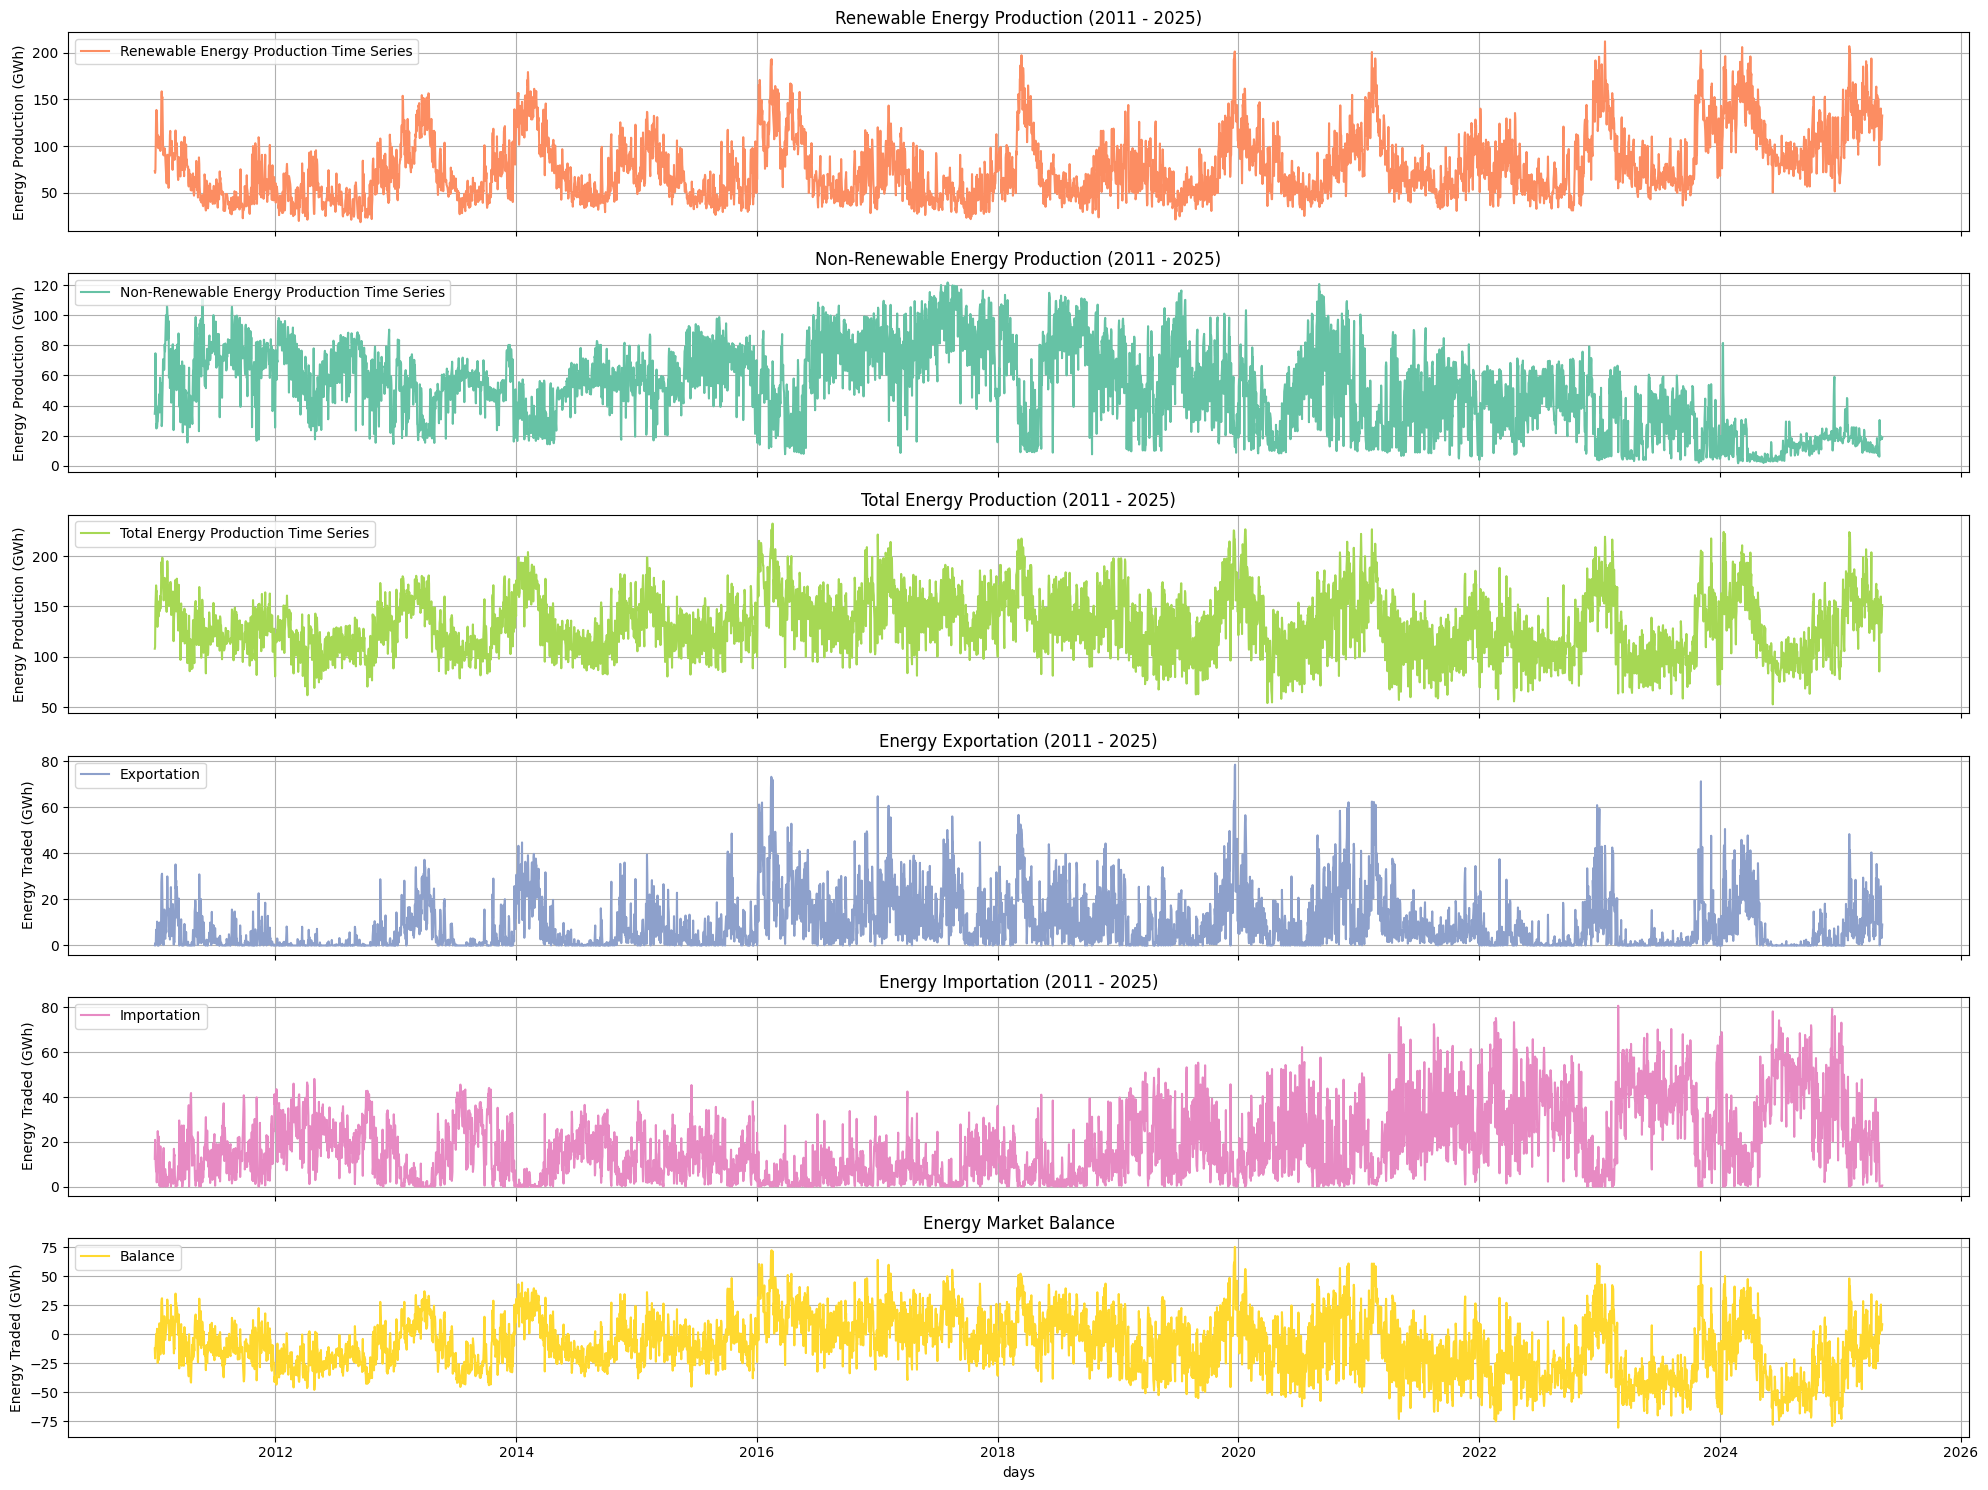

In [10]:
df['liquidez_energia'] = df['exportacao'] - df['importacao']

# Data for plots
plot_data = [
    ('producao_renovavel', title_renewable,
     color_renewable, 'Renewable Energy Production Time Series'),
    ('producao_nao_renovavel', title_non_renewable,
     color_non_renewable, 'Non-Renewable Energy Production Time Series'),
    ('producao_total', 'Total Energy Production (2011 - 2025)',
     colors[4], 'Total Energy Production Time Series'),
    ('exportacao', title_export, color_export, 'Exportation'),
    ('importacao', title_import, color_import, 'Importation'),
    ('liquidez_energia', 'Energy Market Balance', colors[5], 'Balance')
]

fig, axes = plt.subplots(len(plot_data), 1, figsize=(20, 15), sharex=True)

# Loop through data to create subplots
for ax, (column, title, color, label) in zip(axes, plot_data):
    ax.plot(df.index, df[column], label=label, color=color)
    ax.set_title(title)
    ax.set_ylabel("Energy Traded (GWh)" if label in ("Exportation", "Importation", "Balance") else ylab)
    ax.legend()
    ax.legend(loc='upper left')
    ax.grid(True)

axes[-1].set_xlabel(xlab)  # Set x-axis label for the last subplot
plt.tight_layout()

The chart above provides a comprehensive overview of Portugal's energy landscape from 2011 to 2025. Each subplot visualizes a key aspect of the energy system:

- **Renewable and Non-Renewable Production:** The first two plots show the evolution of renewable and non-renewable energy production. Renewable sources generally exhibit higher variability and seasonality, reflecting dependence on natural resources like water and wind. Non-renewable production appears more stable but shows a gradual decline, which might be related to policy shifts and/or increased renewable adoption.

- **Total Energy Production:** This plot combines both renewable and non-renewable sources, highlighting overall production seasonal cycles.

- **Import and Export:** The next two plots illustrate Portugal's cross-border energy flows. Imports consistently surpass exports, highlighting a structural reliance on external energy sources. Both series display pronounced volatility, reflecting market dynamics, seasonal demand, and supply fluctuations. Notably, export spikes often coincide with periods of high renewable generation, suggesting that Portugal exports surplus green energy when available, while imports are likely optimized for cost efficiency or to occasional shortfalls.

- **Energy Market Balance:** The final subplot displays the net energy balance (exports minus imports). Negative values indicate periods of net import, while positive values reflect net export. The balance fluctuates over time, with occasional surpluses but a general tendency toward net import.

Overall, the chart reveals strong seasonality, long-term trends, and the dynamic interplay between production and international energy exchanges.

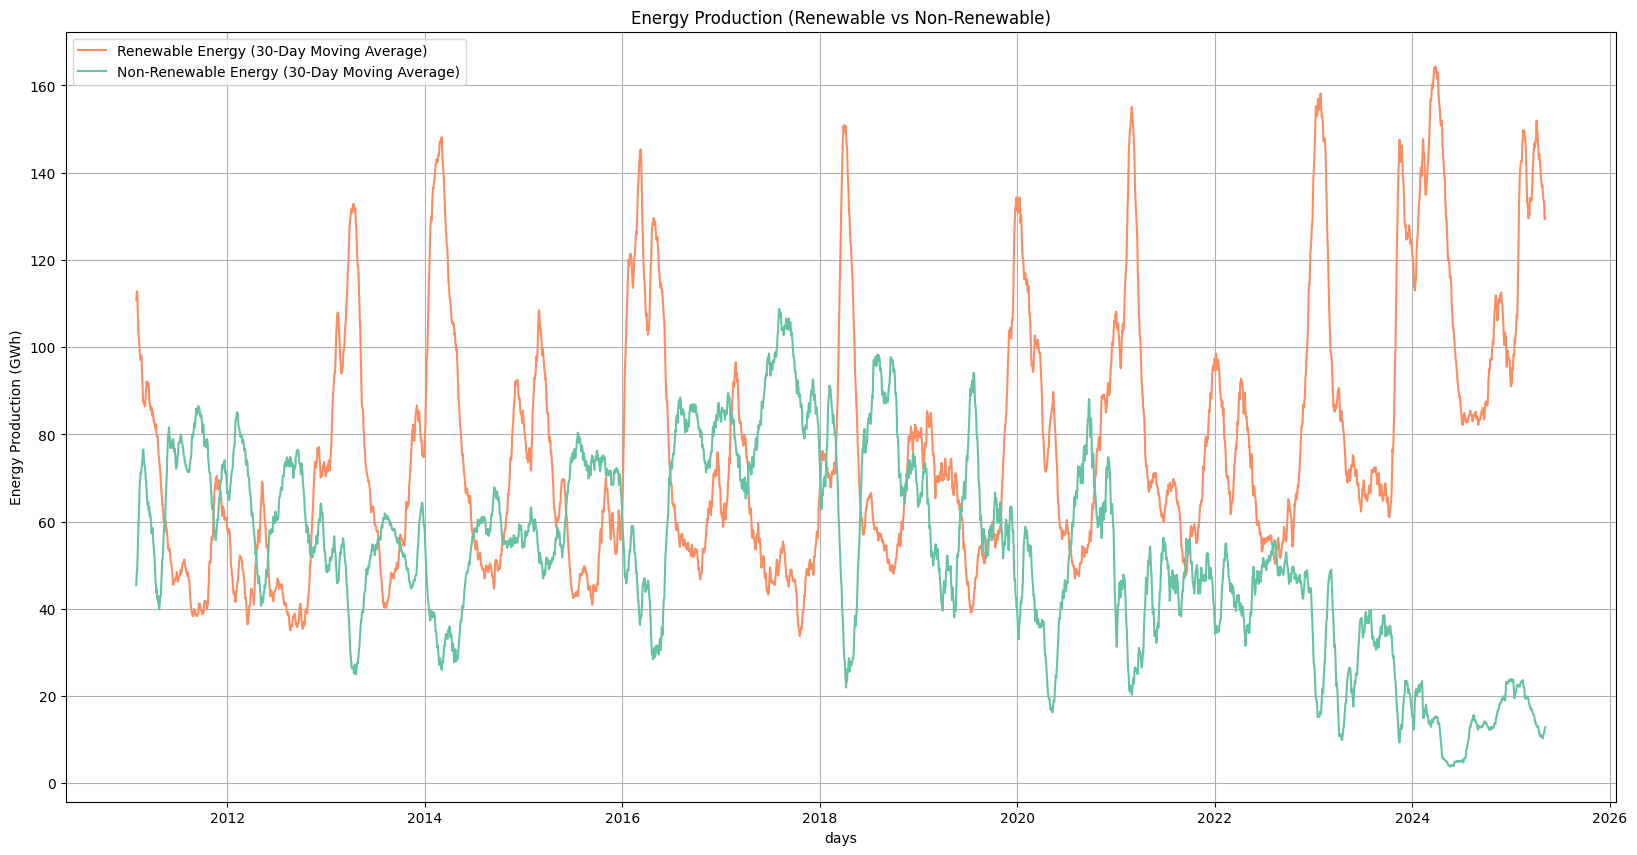

In [11]:
plt.figure(figsize=(20, 10))

# Plot renewable energy production
plt.plot(df.index, df['producao_renovavel'].rolling(window=30).mean(), label='Renewable Energy (30-Day Moving Average)', color=color_renewable)

# Plot non-renewable energy production
plt.plot(df.index, df['producao_nao_renovavel'].rolling(window=30).mean(), label='Non-Renewable Energy (30-Day Moving Average)', color=color_non_renewable)

plt.title('Energy Production (Renewable vs Non-Renewable)')
plt.xlabel(xlab)
plt.ylabel(ylab)
plt.legend()
plt.grid(True)
plt.show()

This line chart compares the 30-day moving averages of renewable and non-renewable energy production in Portugal from 2011 to 2025.

The two series cross multiple times, but from around 2018 onward, renewable production consistently surpasses non-renewable, highlighting Portugal’s transition toward cleaner energy sources. Both series exhibit significant short-term fluctuations, but renewable energy’s variability is more pronounced, likely due to dependence on weather-sensitive sources like hydro and wind. The overall trend demonstrates Portugal’s progress in decarbonizing its energy sector and reducing reliance on non-renewable sources.

This complementary behavior suggests a strong inverse relationship between renewable and non-renewable energy production: when renewable generation increases, reliance on non-renewable sources tends to decrease, and vice versa. Such a pattern may indicate a substitution effect, where renewable sources are prioritized whenever available, reducing the need for fossil fuels. This dynamic highlights the flexibility of the energy system and may point to a causal link, with renewable energy expansion directly contributing to the decline in non-renewable energy usage. Understanding this interplay is crucial for evaluating the effectiveness of policies aimed at decarbonizing the energy sector and achieving sustainability goals.

### Histograms

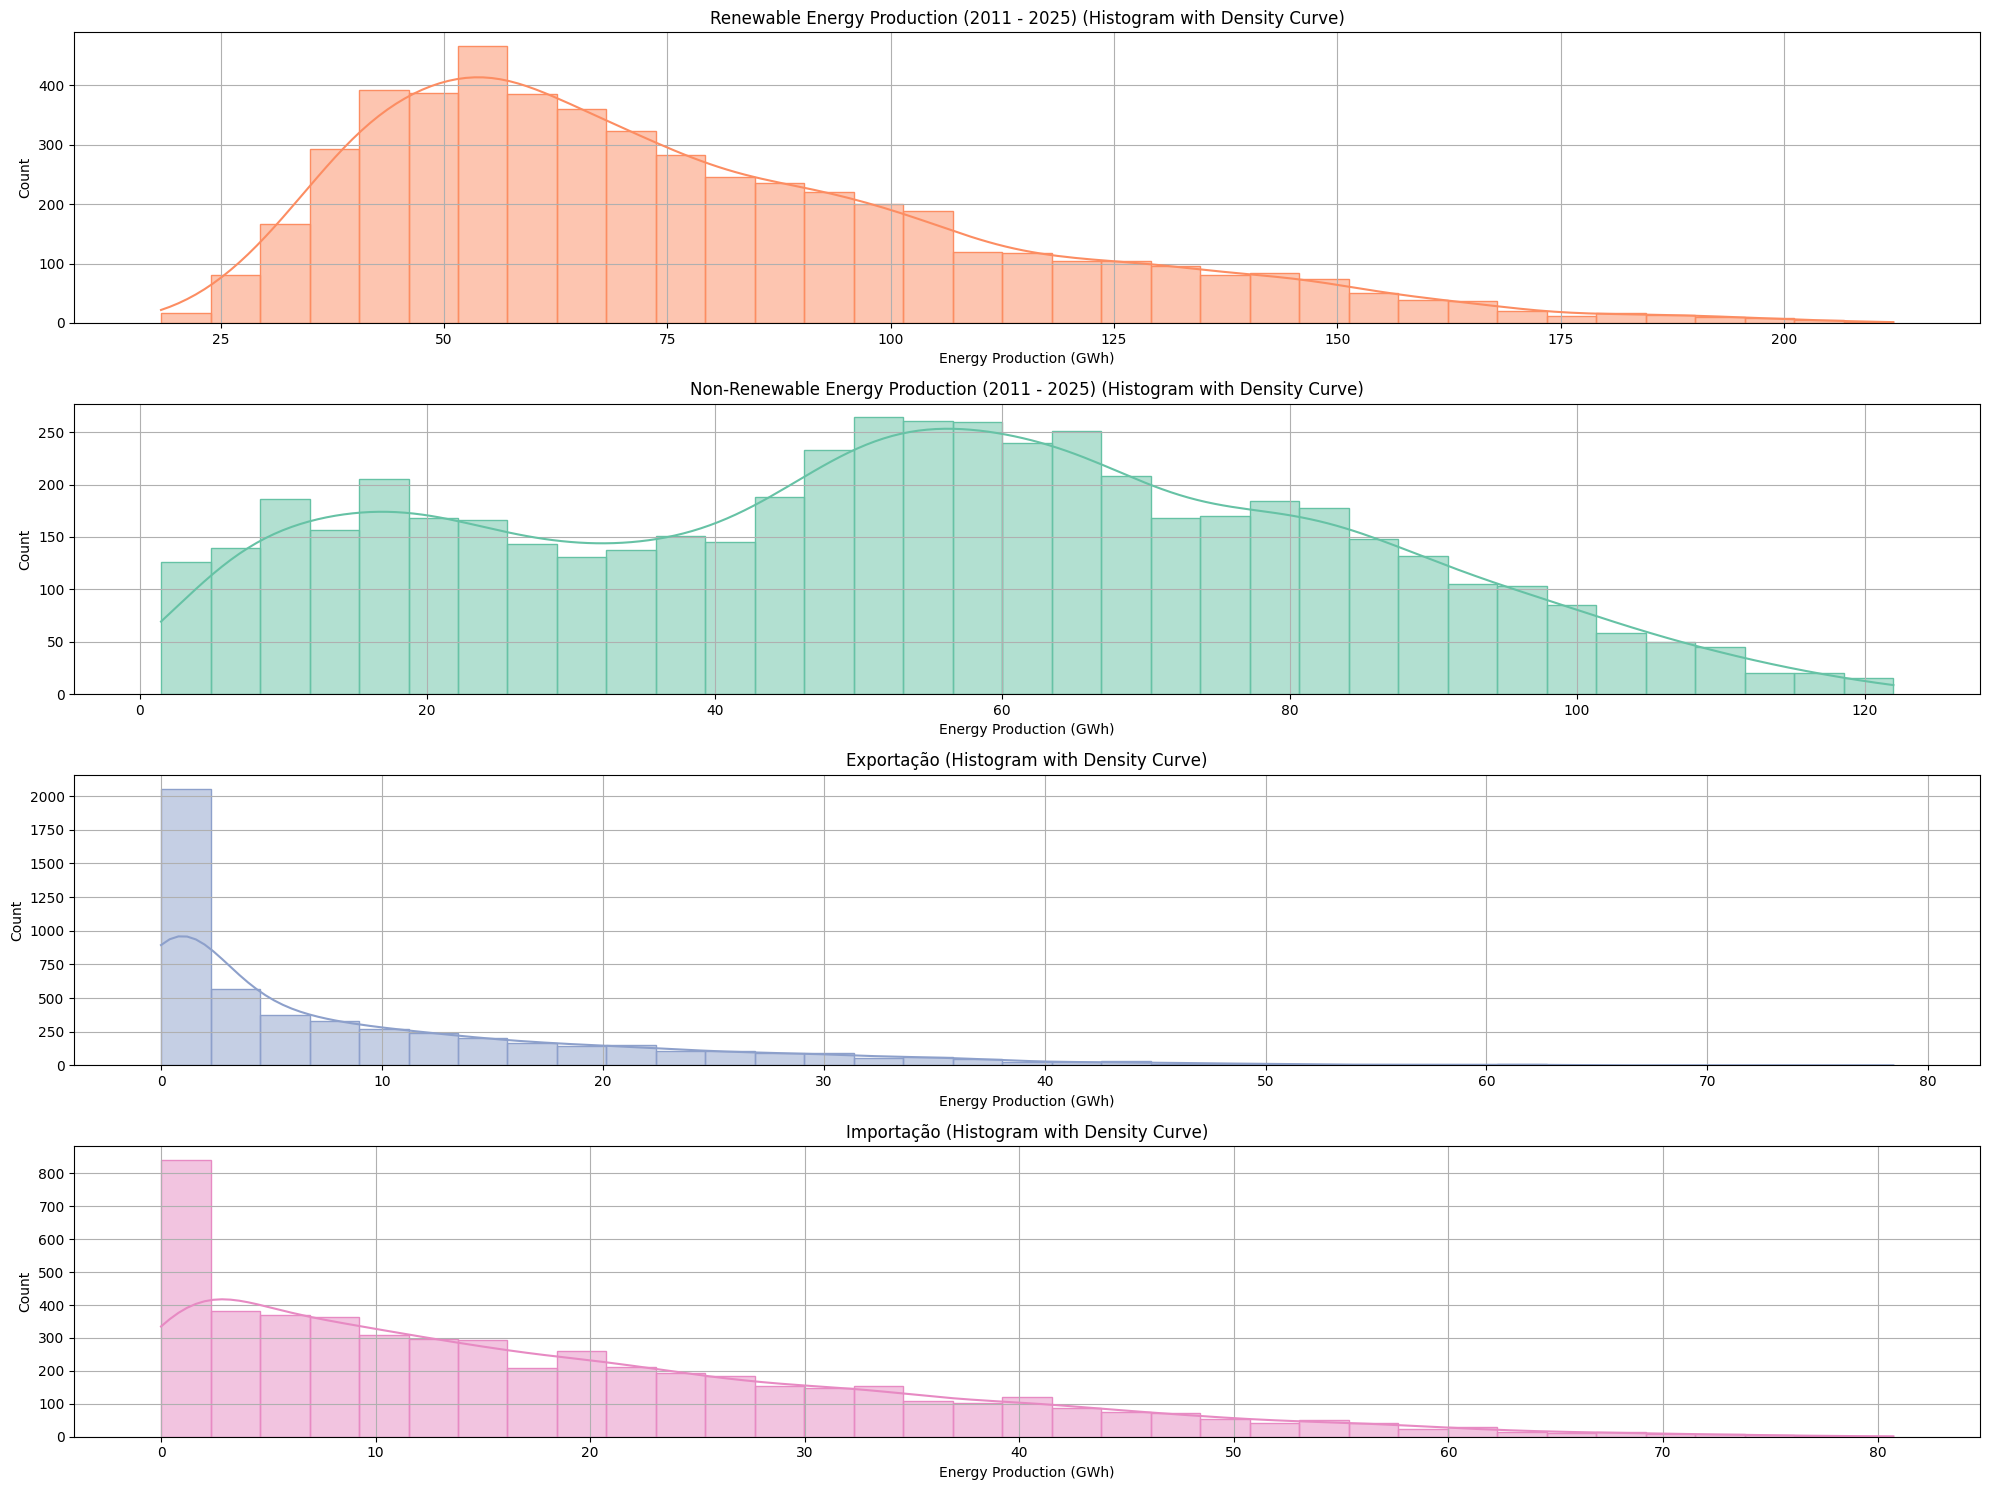

In [12]:
fig, axes = plt.subplots(4, 1, figsize=(20, 15))

# Data for histograms
histogram_data = [
    ('producao_renovavel', title_renewable, color_renewable),
    ('producao_nao_renovavel', title_non_renewable, color_non_renewable),
    ('exportacao', 'Exportação', color_export),
    ('importacao', 'Importação', color_import)
]

# Loop through data to create histograms
for ax, (column, title, color) in zip(axes, histogram_data):
    sns.histplot(df[column], bins=35, color=color,
                 kde=True, edgecolor=color, ax=ax)
    ax.set_title(f'{title} (Histogram with Density Curve)')
    ax.set_xlabel(ylab)
    ax.grid(True)

plt.tight_layout()
plt.show()

The histograms above display the distribution of daily values for renewable energy production, non-renewable energy production, exportation, and importation in Portugal from 2011 to 2025.

- **Renewable Energy Production:** The distribution is right-skewed, with most days concentrated around the mean and a long tail toward higher production values. This reflects the variability and occasional peaks in renewable generation, likely driven by favorable weather conditions.
- **Non-Renewable Energy Production:** The distribution resembles a gaussian mixture with some right skewness. The spread is narrower compared to renewables, indicating more complex distribution to predict outputs from non-renewable sources.
- **Exportation:** The export histogram is heavily right-skewed, with most days showing low export values and a few days with significant spikes. This suggests that Portugal exports large amounts of energy only occasionally, likely during periods of surplus production.
- **Importation:** The import histogram also shows right skewness but with a higher mean and broader spread than exports. This indicates that imports are more frequent and substantial, highlighting Portugal’s reliance on external energy sources during periods of production shortfall.

### Cumulative Distribution Function

In [13]:
df_non_renewable = df['producao_nao_renovavel'].to_frame()
df_renewable = df['producao_renovavel'].to_frame()
df_export = df['exportacao'].to_frame()
df_import = df['importacao'].to_frame()

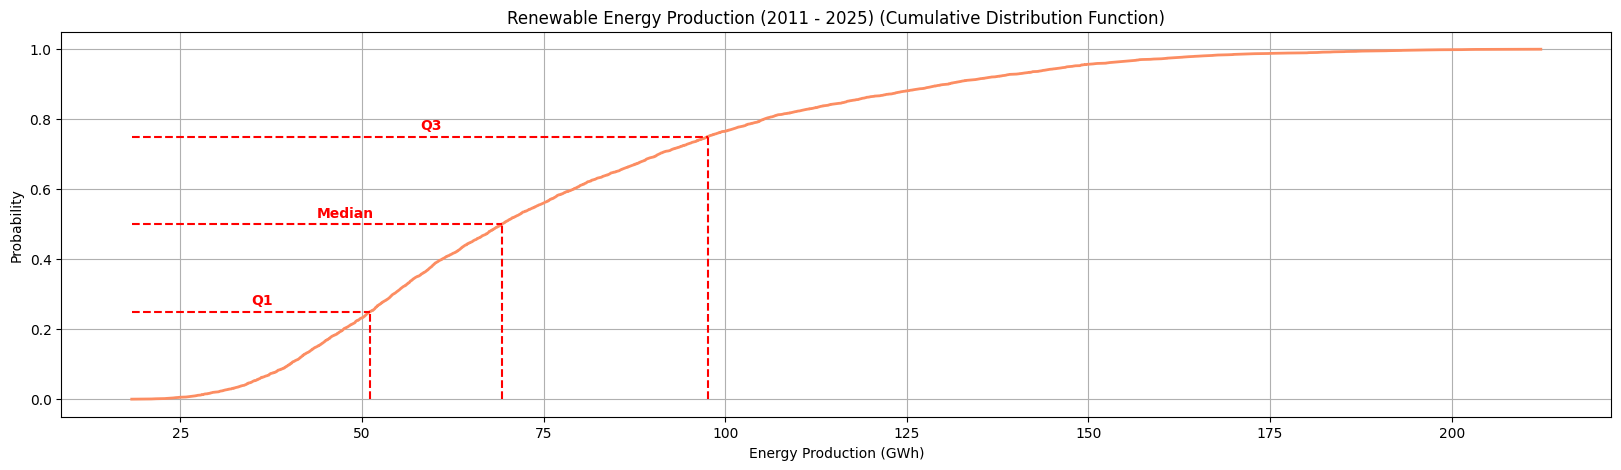

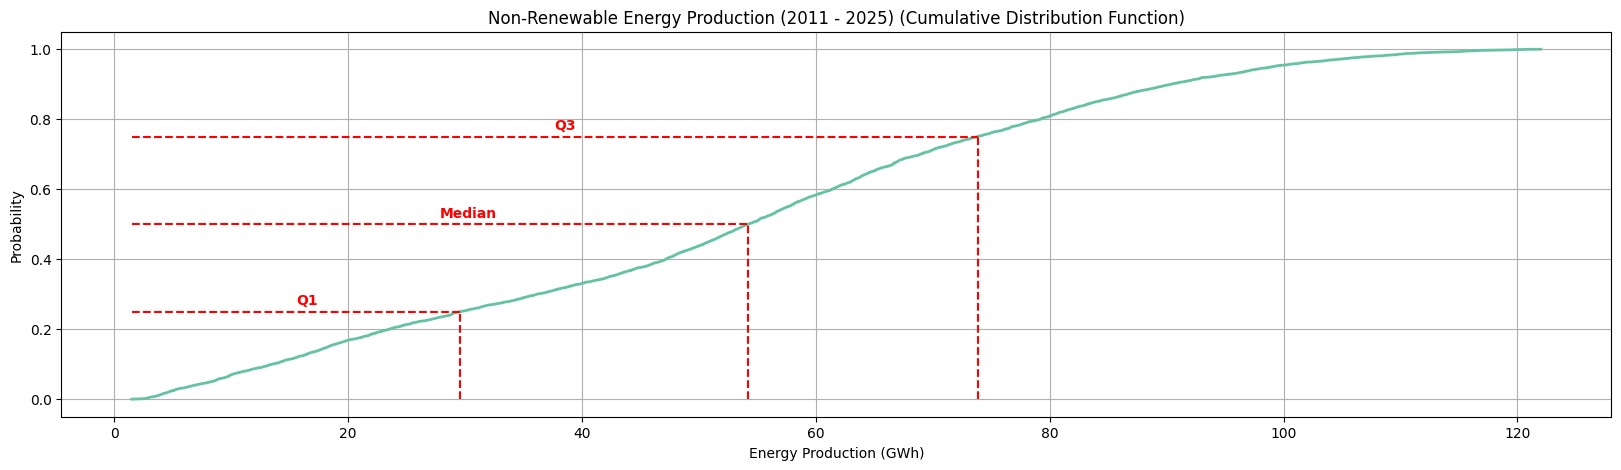

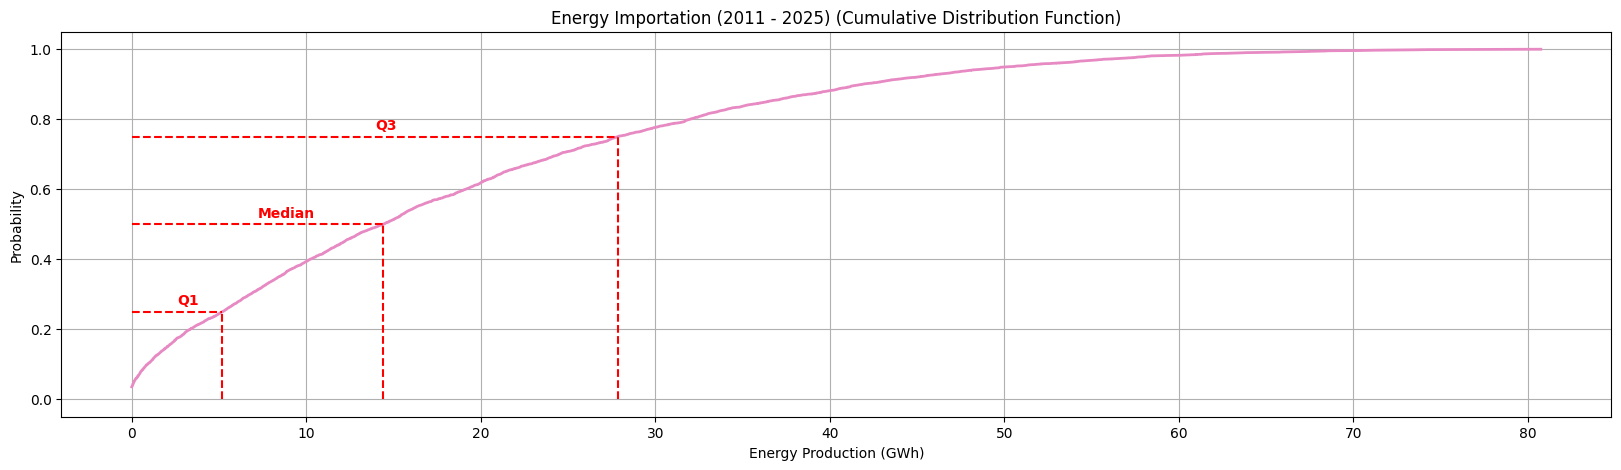

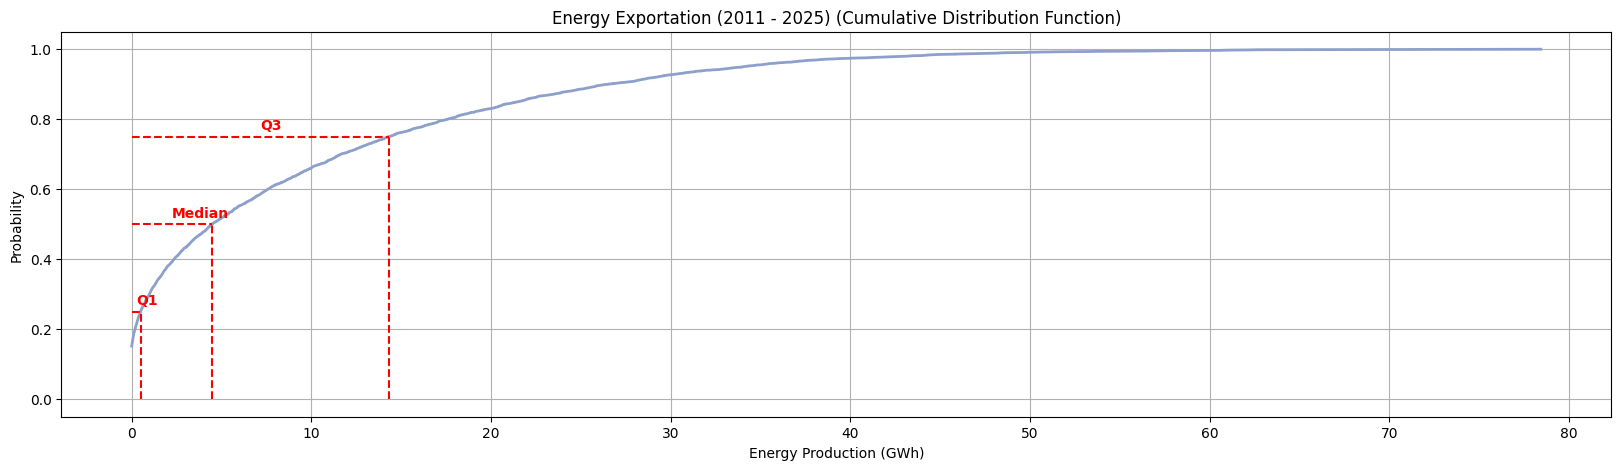

In [14]:
def plot_cdf(data, title, color, y_label, x_label):
    """
    Plots the Cumulative Distribution Function (CDF) for the given data.

    Parameters:
    - data: pandas.DataFrame or pandas.Series
        The data for which the CDF is to be plotted.
    - title: str
        The title of the plot.
    - color: str or tuple
        The color of the plot line.
    - y_label: str
        The label for the y-axis.
    - x_label: str
        The label for the x-axis.
    """
    cdf = data.sum(axis=1).value_counts().sort_index().div(len(data)).cumsum()

    plt.figure(figsize=(20, 5))
    cdf.plot(linewidth=2, color=color)
    plt.title(title + ' (Cumulative Distribution Function)')
    plt.ylabel(y_label)
    plt.xlabel(x_label)

    min_val = data.values.min()
    q25 = np.quantile(data.values, .25)
    median_val = np.quantile(data.values, .5)
    q75 = np.quantile(data.values, .75)

    data_lines = [
        (min_val, q25), (.25, .25), 'r', (q25, q25), (0, .25), 'r',
        (min_val, median_val), (.5, .5), 'r', (median_val, median_val), (0, .5), 'r',
        (min_val, q75), (.75, .75), 'r', (q75, q75), (0, .75), 'r'
    ]
    plt.plot(*data_lines, ls='--')
    plt.text(min_val + (q25 - min_val) / 2, 0.27, "Q1", color='r', fontweight='bold')
    plt.text(min_val + (median_val - min_val) / 2, 0.52, "Median", color='r', fontweight='bold')
    plt.text(min_val + (q75 - min_val) / 2, 0.77, "Q3", color='r', fontweight='bold')
    plt.grid(True)
    plt.show()

# Cumulative Distribution Function for Renewable Energy Production
plot_cdf(
    data=df_renewable,
    title=title_renewable,
    color=color_renewable,
    y_label='Probability',
    x_label=ylab
)

# Cumulative Distribution Function for Non-Renewable Energy Production
plot_cdf(
    data=df_non_renewable,
    title=title_non_renewable,
    color=color_non_renewable,
    y_label='Probability',
    x_label=ylab
)

# Cumulative Distribution Function for Energy Importation
plot_cdf(
    data=df_import,
    title=title_import,
    color=color_import,
    y_label='Probability',
    x_label=ylab
)

# Cumulative Distribution Function for Energy Exportation
plot_cdf(
    data=df_export,
    title=title_export,
    color=color_export,
    y_label='Probability',
    x_label=ylab
)


The Renewable Energy Production CDF shows a sigmoid-like curve with gradual probability increases across production values. Q1 (50 GWh), median (70 GWh), and Q3 (100 GWh) demonstrate the wide interquartile range, reflecting high variability typical of weather-dependent renewable generation. The curve's shape indicates a distribution with moderate skewness where extreme high production values occur with decreasing probability.


The Non-Renewable Energy Production CDF exhibits a more linear rise with a narrower interquartile range (Q1=30 GWh, median=55 GWh, Q3=75 GWh), indicating more consistent and predictable production patterns. The steadier slope suggests a more normally distributed production profile, characteristic of controllable energy sources less affected by external factors.


The Energy Importation CDF shows a logarithmic-like curve where it rises steeply at lower values before gradually flattening, with Q1=5 GWh, median=15 GWh, and Q3=28 GWh. This right-skewed distribution indicates that Portugal typically maintains moderate import levels with occasional high-volume periods, likely during renewable production shortfalls or favorable market conditions.


The Energy Exportation CDF shows a logarithmic-like curve, where this curve strongest concentration is at lower values (Q1=1 GWh, median=5 GWh, Q3=15 GWh), with the steepest initial rise of all four metrics. This highly right-skewed distribution reveals that Portugal generally exports minimal energy, with significant export volumes occurring only during exceptional production surpluses.

### Data Distribution Over Year

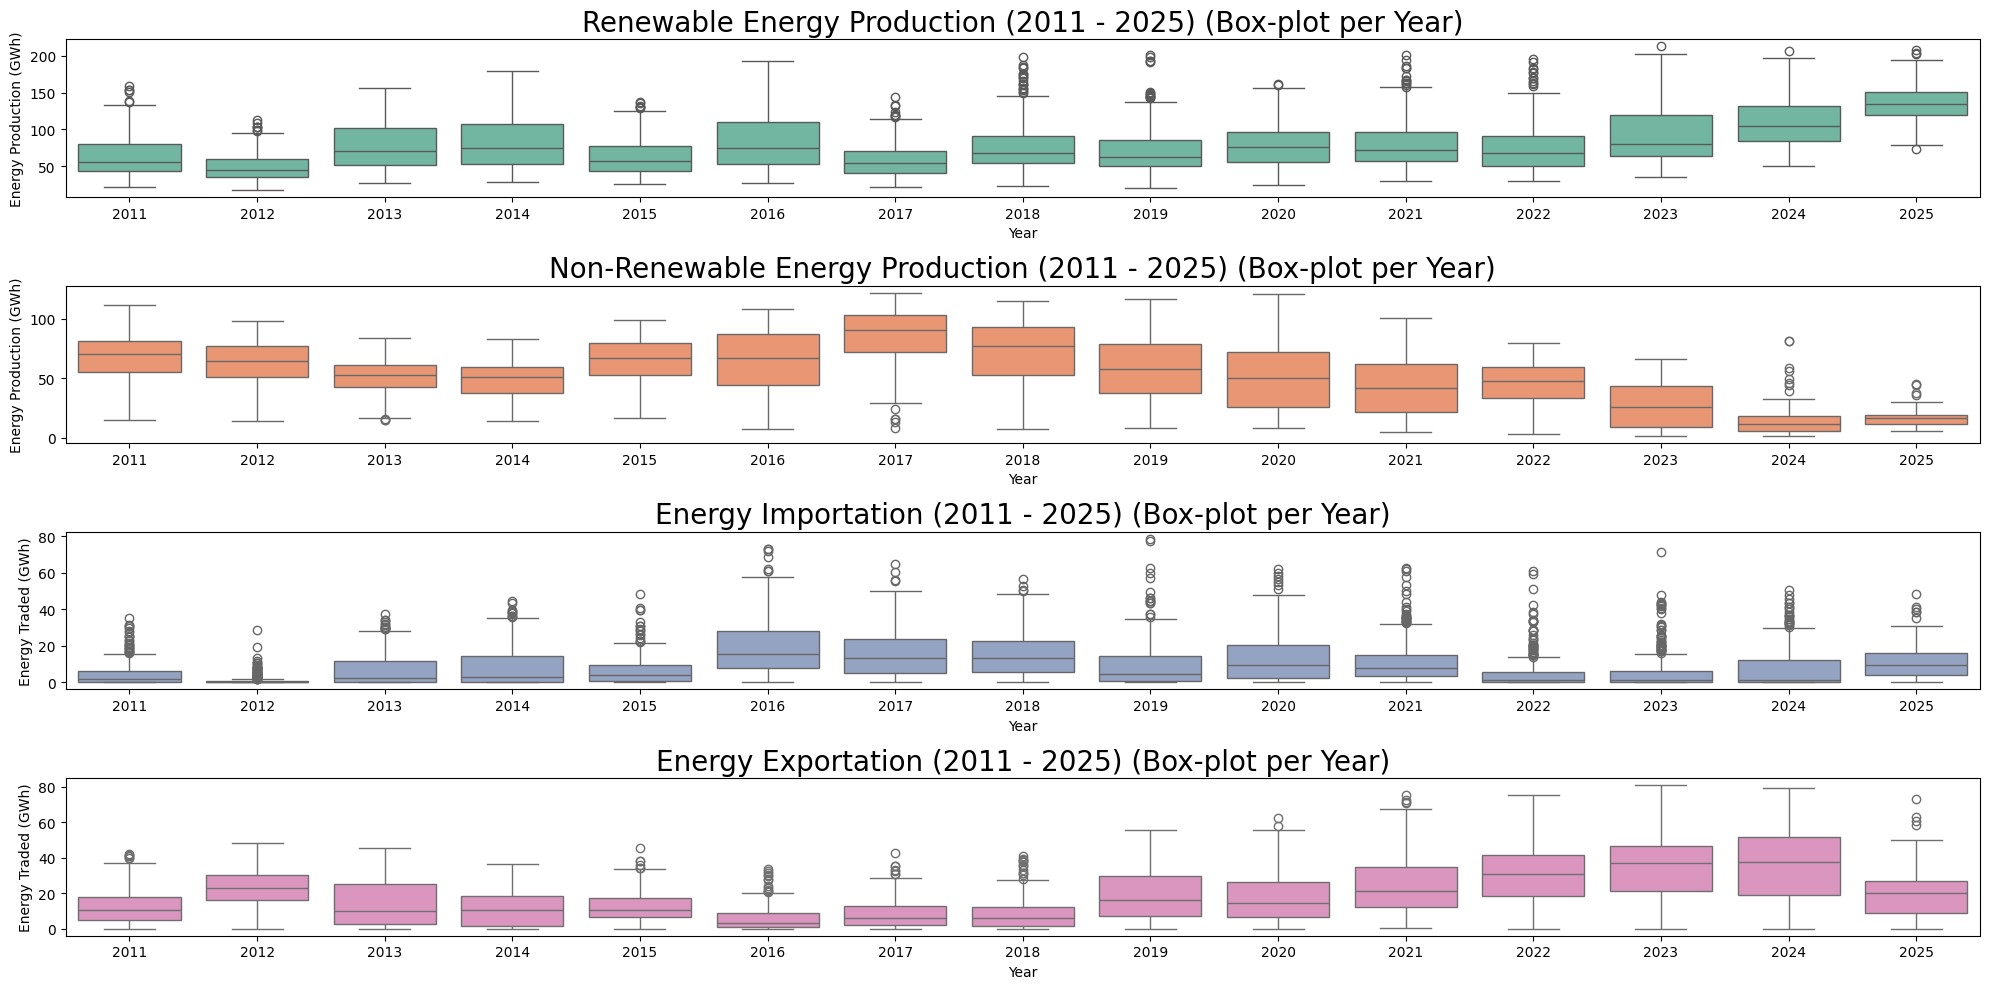

In [15]:
plt.figure(figsize=(20, 10))

# Define a list of data and titles for the box plots with improved color scheme
boxplot_data = [
    (df_renewable, 'producao_renovavel', colors[0], title_renewable),
    (df_non_renewable, 'producao_nao_renovavel', colors[1], title_non_renewable),
    (df_export, 'exportacao', colors[2], title_import),
    (df_import, 'importacao', colors[3], title_export)
]

# Loop through the data to create subplots
for i, (data, column, color, title) in enumerate(boxplot_data, start=1):
    plt.subplot(4, 1, i)
    box_plot = sns.boxplot(x=df.index.year, y=column, data=data, color=color)
    box_plot.set_xlabel('Year')
    box_plot.set_ylabel("Energy Traded (GWh)" if title in (title_import, title_export) else ylab)
    box_plot.set_title(f'{title} (Box-plot per Year)', fontsize=20)

plt.tight_layout()
plt.show()

Renewable Energy Production shows a generally increasing trend from 2011 to 2025, with notable variability throughout. The median renewable production rises substantially after 2020, with 2023-2025 showing both higher median values and wider ranges. There are also some outliers representing days where the production peaked. The only lower outlier could represent the massive outage on April 28th 2025.

Non-Renewable Energy Production displays a clear declining trend, particularly after 2017. The highest median values appear in that year, followed by a consistent decrease. The interquartile range also narrows in later years.

Energy Importation shows significant volatility, with peak median imports occurring around 2016-2018.

Energy Exportation exhibits increasing capability over time, with particularly high values in 2022-2024. The widening boxes in later years indicate greater variability in export volumes, likely corresponding to surplus renewable generation during favorable conditions.

### Time Series Decomposition Analysis

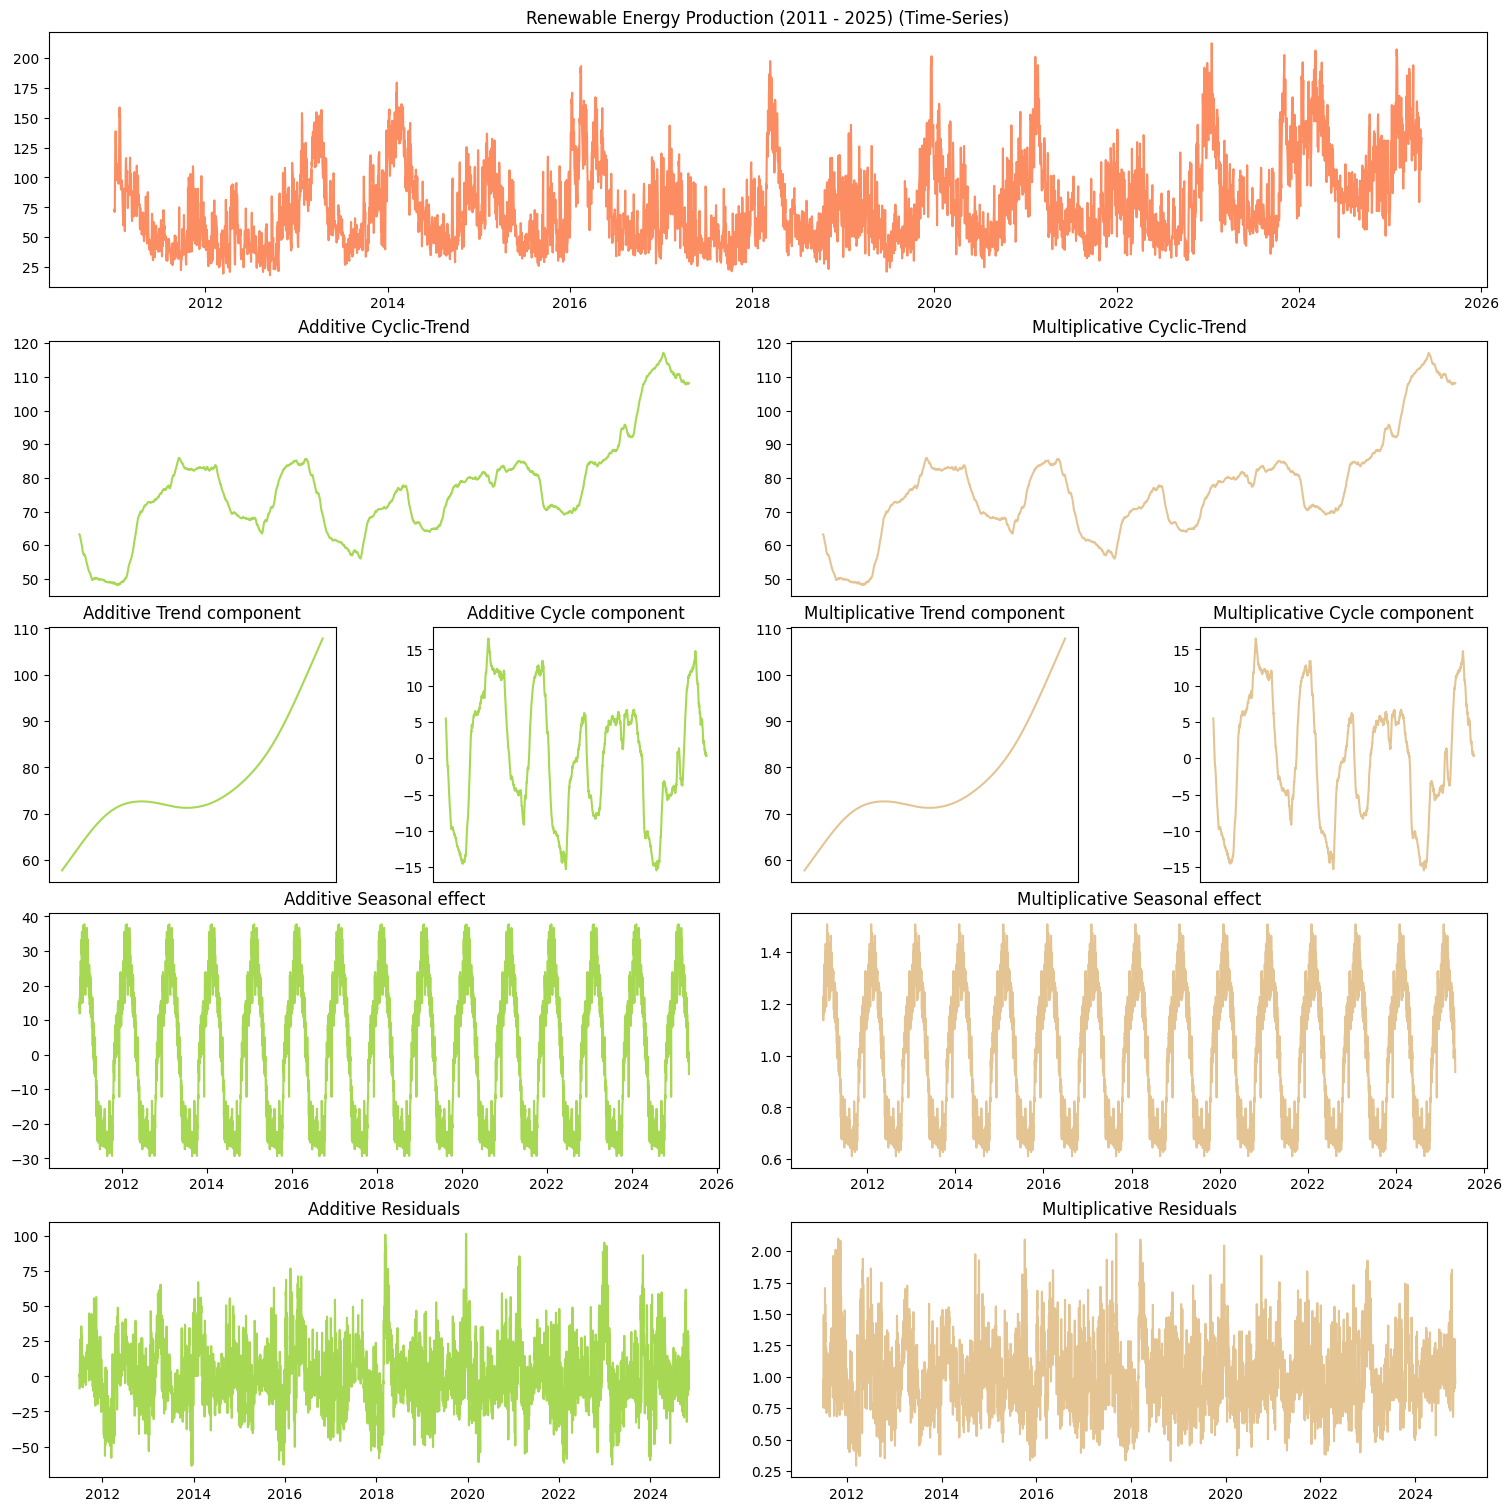

In [16]:
resultAdd = seasonal_decompose(df_renewable, model='additive', period=seasonal_periods)
resultMul = seasonal_decompose(df_renewable, model='multiplicative', period=seasonal_periods)

# Hodrick-Prescott filter
lamb = 107360000000
cycleAdd, trendAdd = sm.tsa.filters.hpfilter(resultAdd.trend.dropna(), lamb=lamb)
cycleMul, trendMul = sm.tsa.filters.hpfilter(resultMul.trend.dropna(), lamb=lamb)

fig = plt.figure(figsize=(15, 15), constrained_layout=True)
spec = gridspec.GridSpec(ncols=4, nrows=5, figure=fig)

# Plot original time series
fig.add_subplot(spec[0, :])
plt.plot(df_renewable, color=color_renewable)
plt.title(title_renewable + ' (Time-Series)')

# Additive and Multiplicative components
components = [
    (resultAdd.trend, 'Additive Cyclic-Trend', spec[1, :2]),
    (trendAdd, 'Additive Trend component', spec[2, 0]),
    (cycleAdd, 'Additive Cycle component', spec[2, 1]),
    (resultAdd.seasonal, 'Additive Seasonal effect', spec[3, :2]),
    (resultAdd.resid, 'Additive Residuals', spec[4, :2]),
    (resultMul.trend, 'Multiplicative Cyclic-Trend', spec[1, 2:]),
    (trendMul, 'Multiplicative Trend component', spec[2, 2]),
    (cycleMul, 'Multiplicative Cycle component', spec[2, 3]),
    (resultMul.seasonal, 'Multiplicative Seasonal effect', spec[3, 2:]),
    (resultMul.resid, 'Multiplicative Residuals', spec[4, 2:])
]

for data, title, position in components:
    ax = fig.add_subplot(position)
    ax.plot(data, color=colors[4] if 'Additive' in title else colors[6])
    ax.set_title(title)
    if 'Trend' in title or 'Cycle' in title:
        ax.set_xticks([])

plt.show()


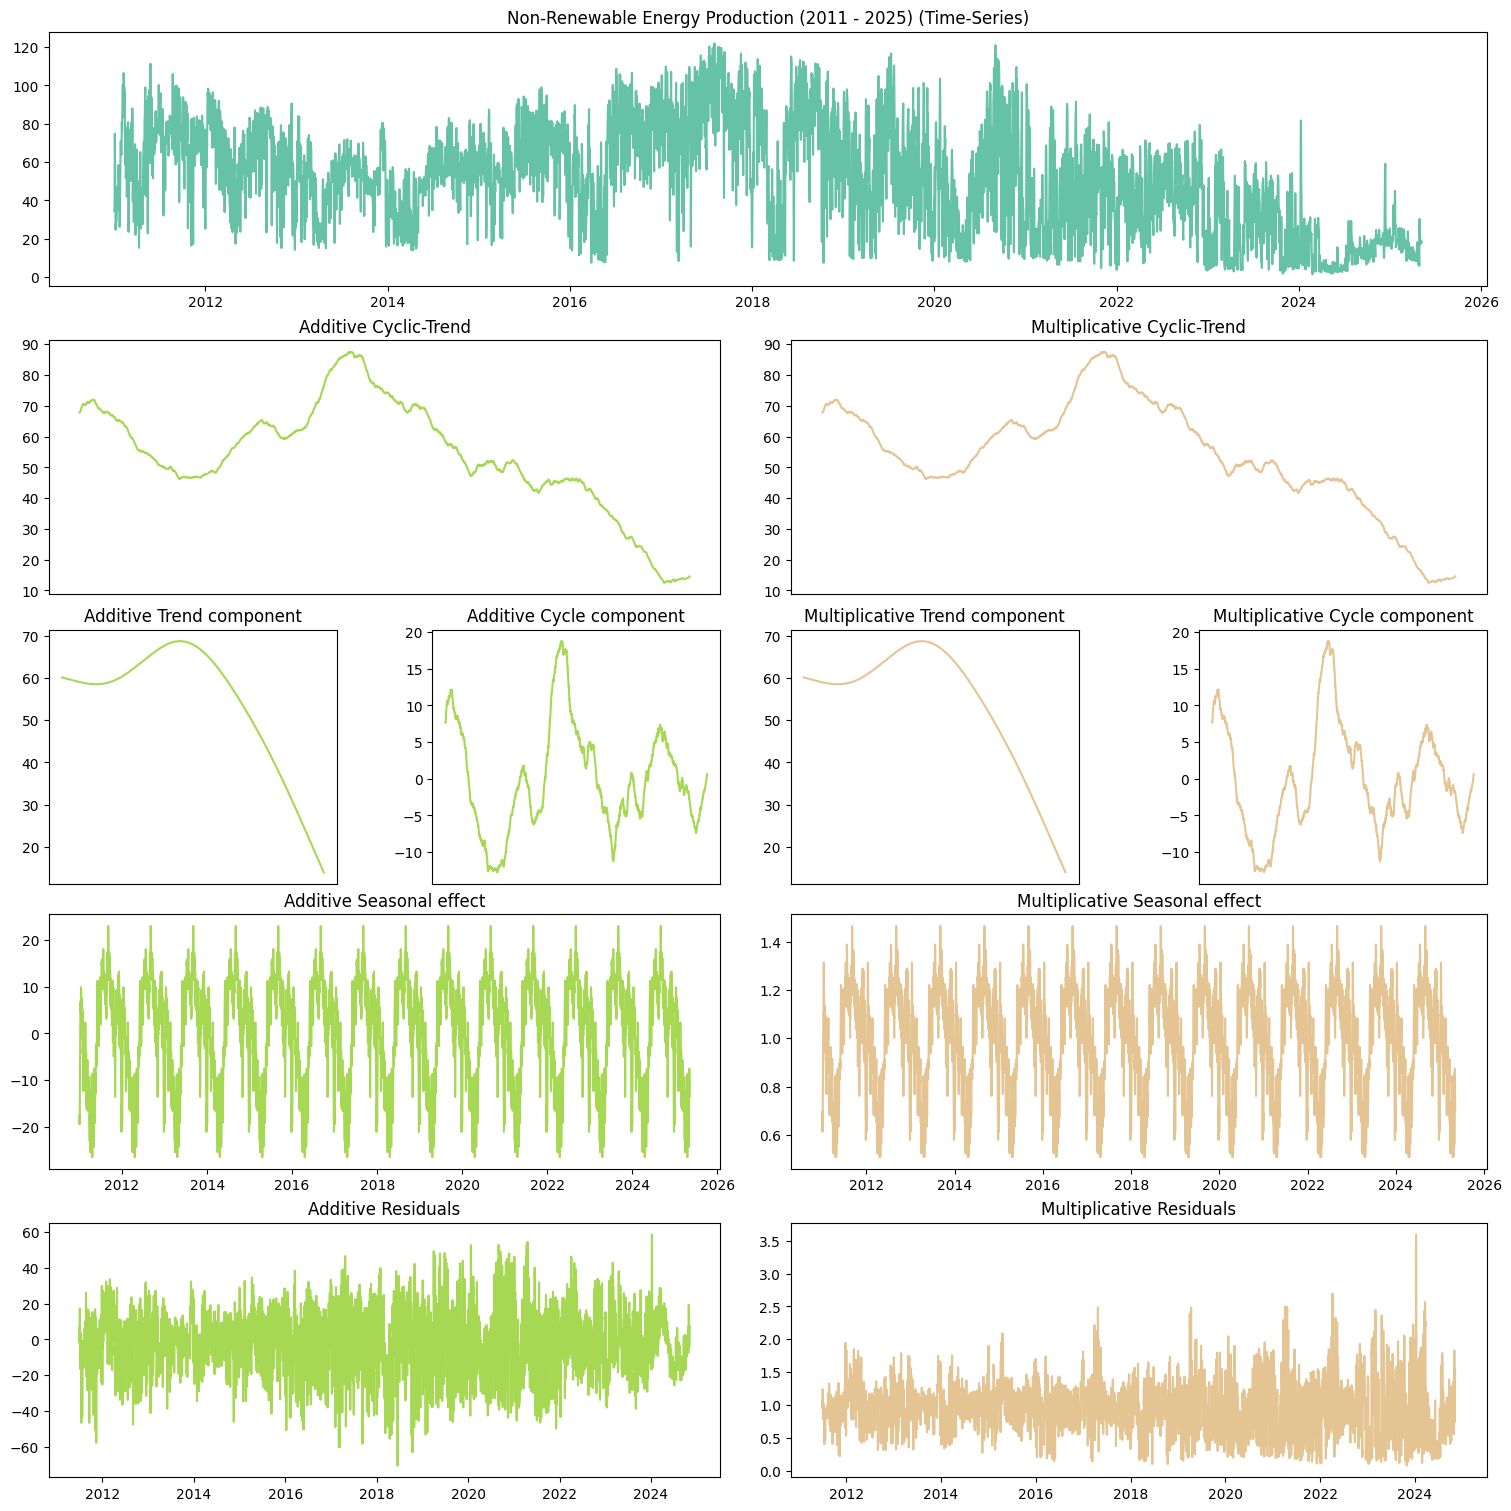

In [17]:
resultAdd = seasonal_decompose(df_non_renewable, model='additive', period=seasonal_periods)
resultMul = seasonal_decompose(df_non_renewable, model='multiplicative', period=seasonal_periods)

# Hodrick-Prescott filter
lamb = 107360000000
cycleAdd, trendAdd = sm.tsa.filters.hpfilter(resultAdd.trend.dropna(), lamb=lamb)
cycleMul, trendMul = sm.tsa.filters.hpfilter(resultMul.trend.dropna(), lamb=lamb)

fig = plt.figure(figsize=(15, 15), constrained_layout=True)
spec = gridspec.GridSpec(ncols=4, nrows=5, figure=fig)

# Plot original time series
fig.add_subplot(spec[0, :])
plt.plot(df_non_renewable, color=color_non_renewable)
plt.title(title_non_renewable + ' (Time-Series)')

# Additive and Multiplicative components
components = [
    (resultAdd.trend, 'Additive Cyclic-Trend', spec[1, :2]),
    (trendAdd, 'Additive Trend component', spec[2, 0]),
    (cycleAdd, 'Additive Cycle component', spec[2, 1]),
    (resultAdd.seasonal, 'Additive Seasonal effect', spec[3, :2]),
    (resultAdd.resid, 'Additive Residuals', spec[4, :2]),
    (resultMul.trend, 'Multiplicative Cyclic-Trend', spec[1, 2:]),
    (trendMul, 'Multiplicative Trend component', spec[2, 2]),
    (cycleMul, 'Multiplicative Cycle component', spec[2, 3]),
    (resultMul.seasonal, 'Multiplicative Seasonal effect', spec[3, 2:]),
    (resultMul.resid, 'Multiplicative Residuals', spec[4, 2:])
]

for data, title, position in components:
    ax = fig.add_subplot(position)
    ax.plot(data, color=colors[4] if 'Additive' in title else colors[6])
    ax.set_title(title)
    if 'Trend' in title or 'Cycle' in title:
        ax.set_xticks([])

plt.show()

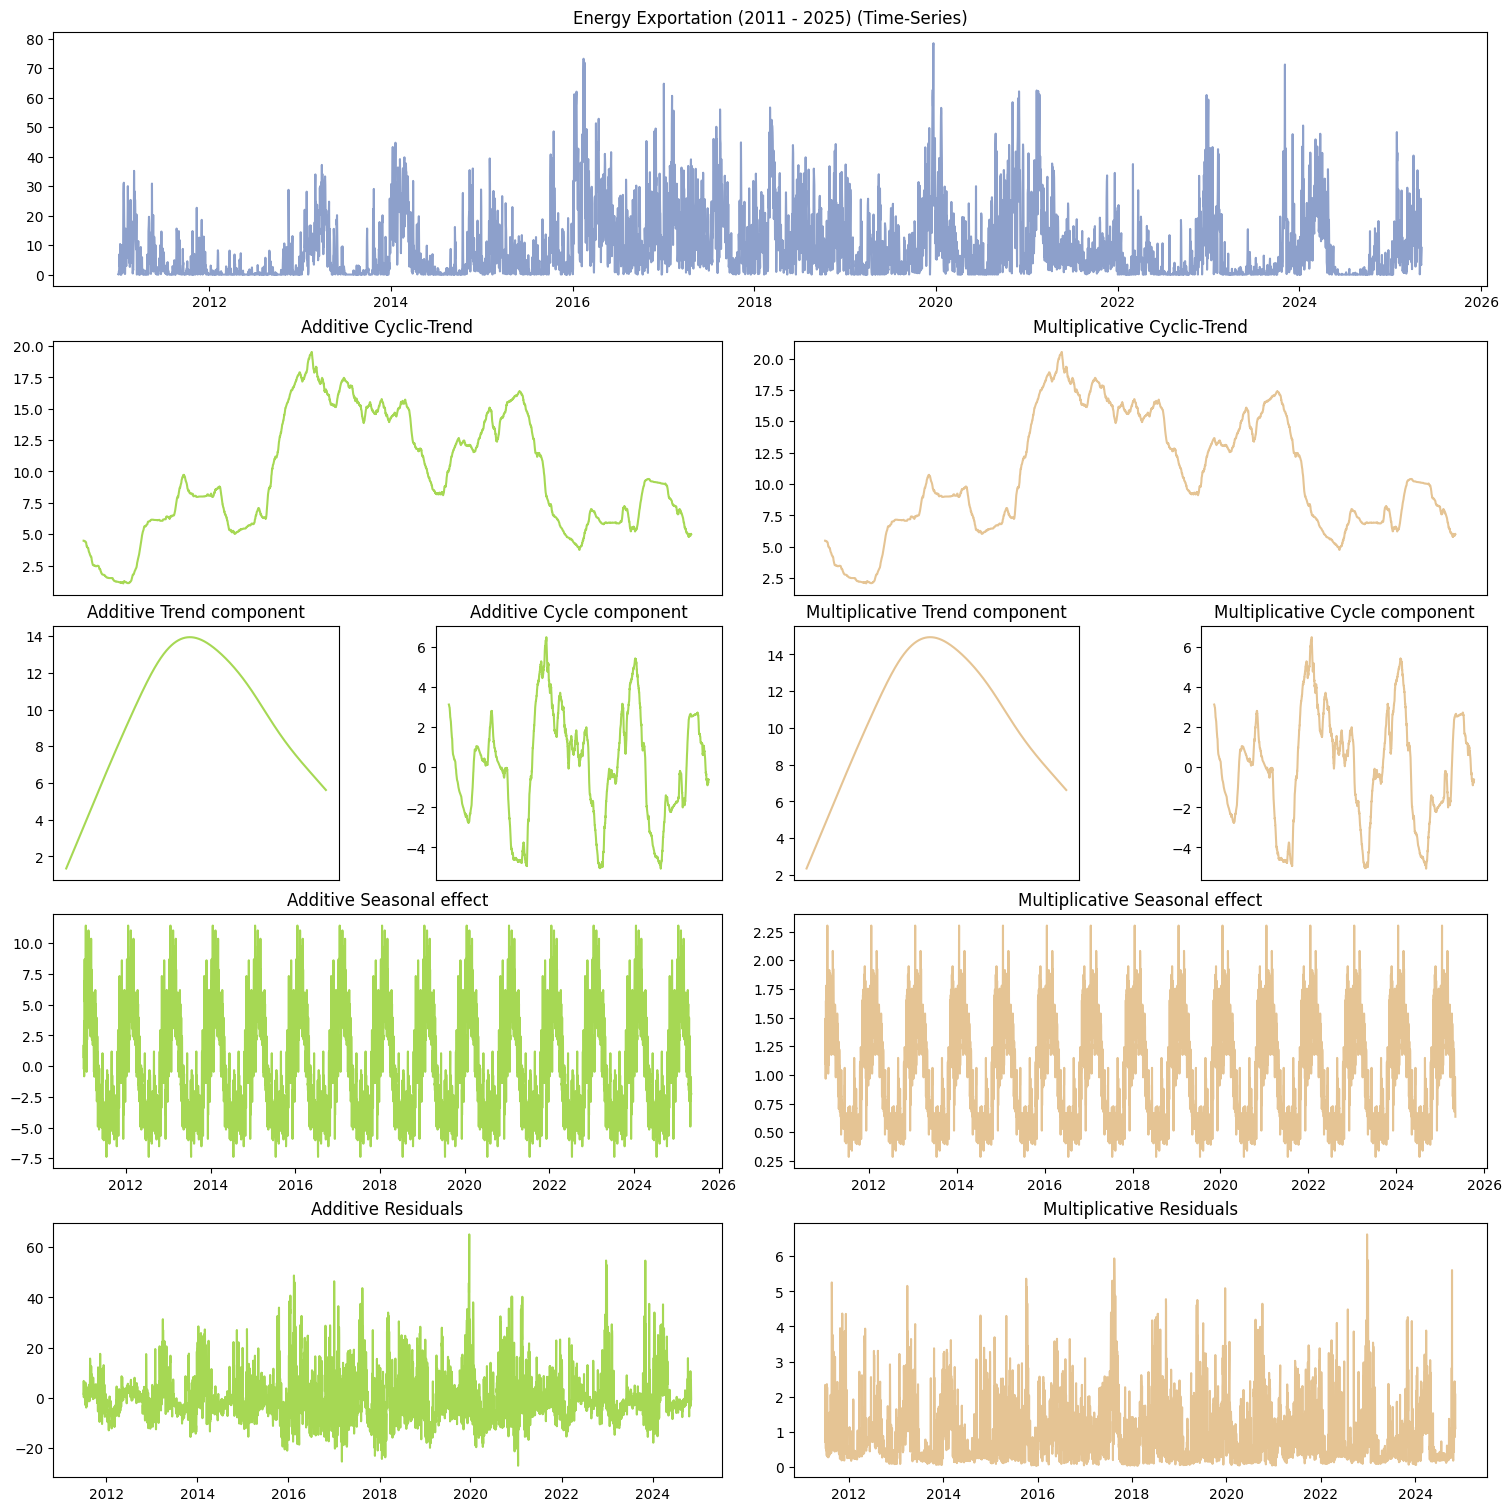

In [19]:
resultAdd = seasonal_decompose(df_export, model='additive', period=seasonal_periods)
resultMul = seasonal_decompose(df_export + 1, model='multiplicative', period=seasonal_periods)

# Hodrick-Prescott filter
lamb = 107360000000
cycleAdd, trendAdd = sm.tsa.filters.hpfilter(resultAdd.trend.dropna(), lamb=lamb)
cycleMul, trendMul = sm.tsa.filters.hpfilter(resultMul.trend.dropna(), lamb=lamb)

fig = plt.figure(figsize=(15, 15), constrained_layout=True)
spec = gridspec.GridSpec(ncols=4, nrows=5, figure=fig)

# Plot original time series
fig.add_subplot(spec[0, :])
plt.plot(df_export, color=color_export)
plt.title(title_export + ' (Time-Series)')

# Additive and Multiplicative components
components = [
    (resultAdd.trend, 'Additive Cyclic-Trend', spec[1, :2]),
    (trendAdd, 'Additive Trend component', spec[2, 0]),
    (cycleAdd, 'Additive Cycle component', spec[2, 1]),
    (resultAdd.seasonal, 'Additive Seasonal effect', spec[3, :2]),
    (resultAdd.resid, 'Additive Residuals', spec[4, :2]),
    (resultMul.trend, 'Multiplicative Cyclic-Trend', spec[1, 2:]),
    (trendMul, 'Multiplicative Trend component', spec[2, 2]),
    (cycleMul, 'Multiplicative Cycle component', spec[2, 3]),
    (resultMul.seasonal, 'Multiplicative Seasonal effect', spec[3, 2:]),
    (resultMul.resid, 'Multiplicative Residuals', spec[4, 2:])
]

for data, title, position in components:
    ax = fig.add_subplot(position)
    ax.plot(data, color=colors[4] if 'Additive' in title else colors[6])
    ax.set_title(title)
    if 'Trend' in title or 'Cycle' in title:
        ax.set_xticks([])

plt.show()

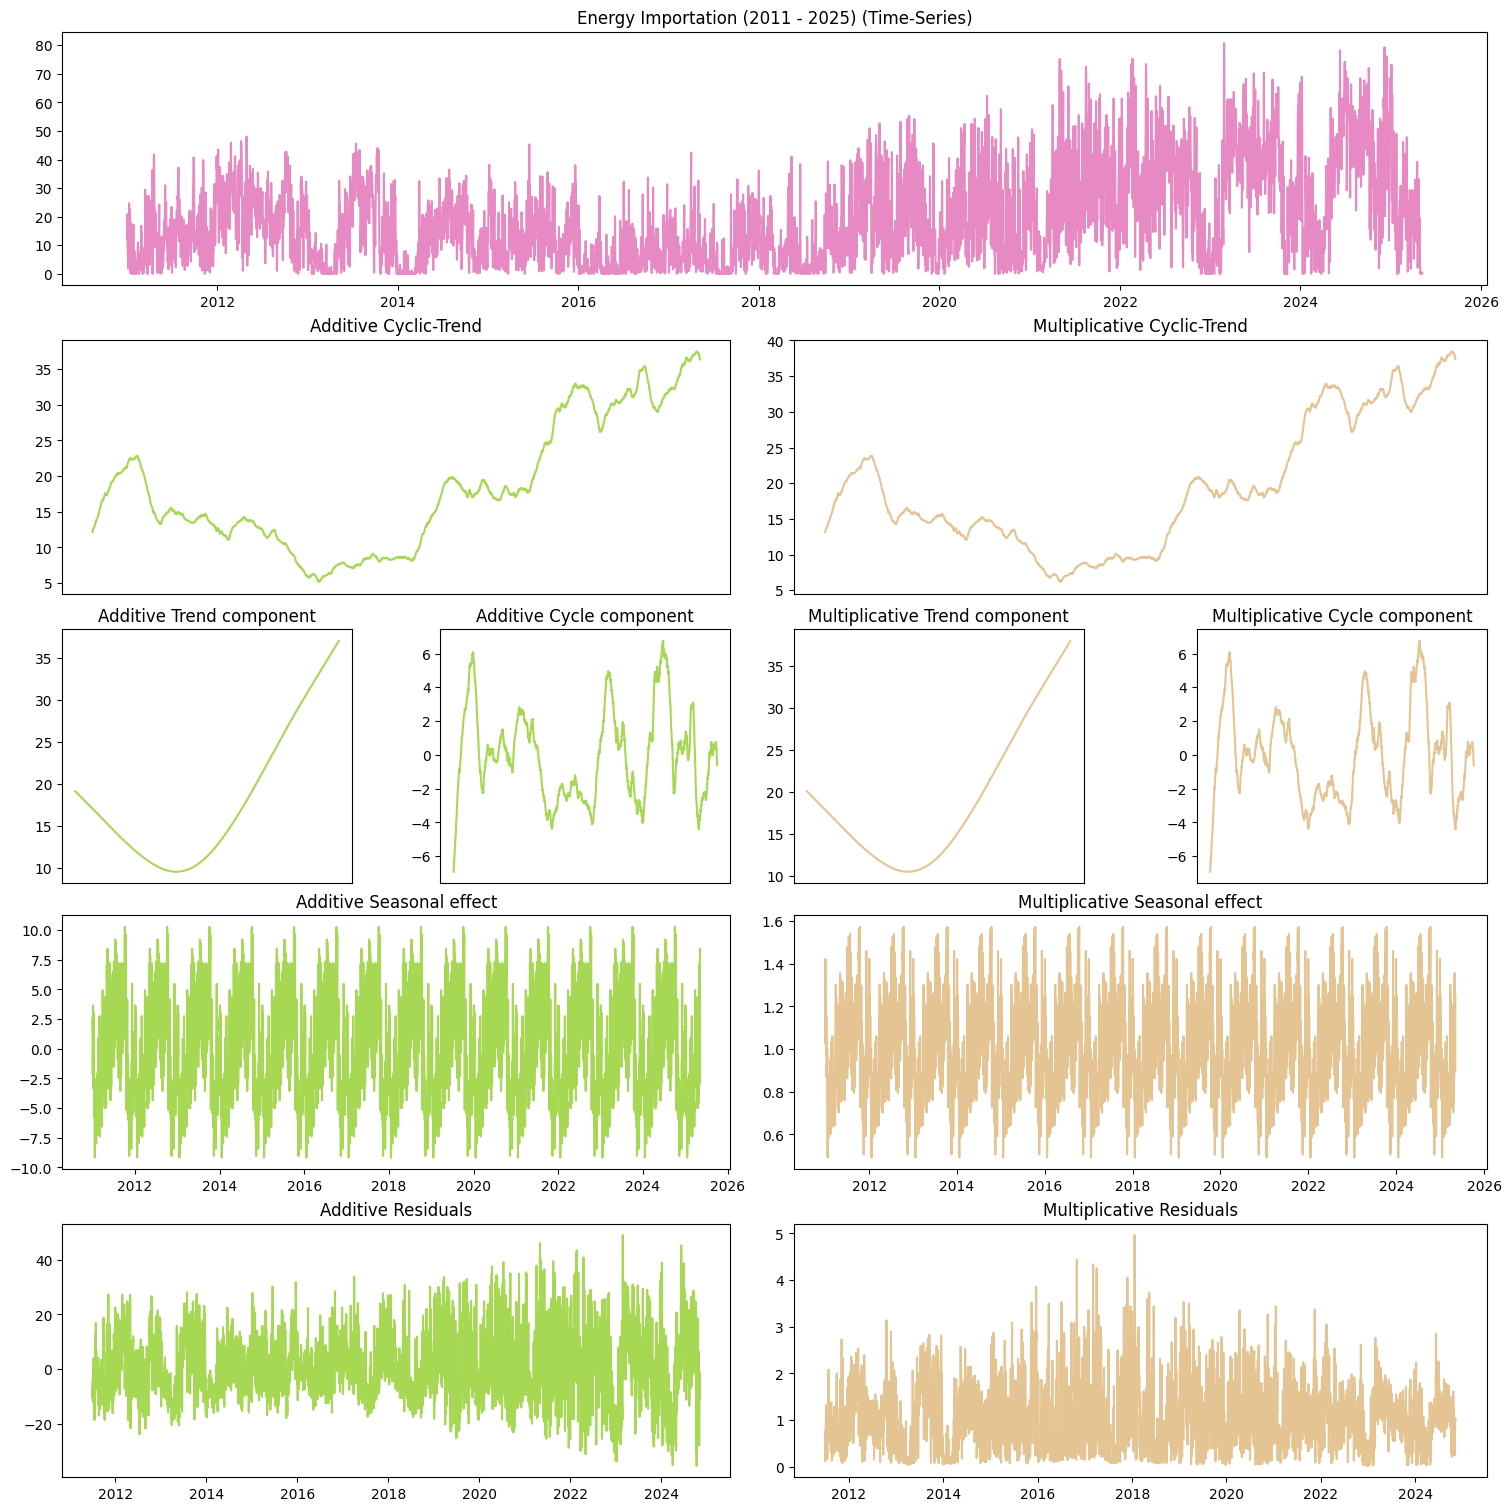

In [21]:
resultAdd = seasonal_decompose(df_import, model='additive', period=seasonal_periods)
resultMul = seasonal_decompose(df_import + 1, model='multiplicative', period=seasonal_periods)

# Hodrick-Prescott filter
lamb = 107360000000
cycleAdd, trendAdd = sm.tsa.filters.hpfilter(resultAdd.trend.dropna(), lamb=lamb)
cycleMul, trendMul = sm.tsa.filters.hpfilter(resultMul.trend.dropna(), lamb=lamb)

fig = plt.figure(figsize=(15, 15), constrained_layout=True)
spec = gridspec.GridSpec(ncols=4, nrows=5, figure=fig)

# Plot original time series
fig.add_subplot(spec[0, :])
plt.plot(df_import, color=color_import)
plt.title(title_import + ' (Time-Series)')

# Additive and Multiplicative components
components = [
    (resultAdd.trend, 'Additive Cyclic-Trend', spec[1, :2]),
    (trendAdd, 'Additive Trend component', spec[2, 0]),
    (cycleAdd, 'Additive Cycle component', spec[2, 1]),
    (resultAdd.seasonal, 'Additive Seasonal effect', spec[3, :2]),
    (resultAdd.resid, 'Additive Residuals', spec[4, :2]),
    (resultMul.trend, 'Multiplicative Cyclic-Trend', spec[1, 2:]),
    (trendMul, 'Multiplicative Trend component', spec[2, 2]),
    (cycleMul, 'Multiplicative Cycle component', spec[2, 3]),
    (resultMul.seasonal, 'Multiplicative Seasonal effect', spec[3, 2:]),
    (resultMul.resid, 'Multiplicative Residuals', spec[4, 2:])
]

for data, title, position in components:
    ax = fig.add_subplot(position)
    ax.plot(data, color=colors[4] if 'Additive' in title else colors[6])
    ax.set_title(title)
    if 'Trend' in title or 'Cycle' in title:
        ax.set_xticks([])

plt.show()

### Time Series Strength Metrics

In [ ]:
# Calculate strengths for each series
strengths_renewable = calculate_strengths(df_renewable['producao_renovavel'], 'additive')
strengths_non_renewable = calculate_strengths(df_non_renewable['producao_nao_renovavel'], 'additive')
strengths_export = calculate_strengths(df_export['exportacao'], 'additive')
strengths_import = calculate_strengths(df_import['importacao'], 'additive')

# Create a DataFrame to display strength metrics
additive_strength_metrics = pd.DataFrame({
    'Energy Type': ['Renewable Energy', 'Non-Renewable Energy', 'Energy Exportation', 'Energy Importation'],
    'Trend Strength': [strengths_renewable[0], strengths_non_renewable[0], strengths_export[0], strengths_import[0]],
    'Seasonality Strength': [strengths_renewable[1], strengths_non_renewable[1], strengths_export[1], strengths_import[1]]
})

# Format the values as percentages with 2 decimal places
additive_strength_metrics['Trend Strength'] = additive_strength_metrics['Trend Strength'].map('{:.3%}'.format)
additive_strength_metrics['Seasonality Strength'] = additive_strength_metrics['Seasonality Strength'].map('{:.3%}'.format)

# Display the formatted DataFrame
display(additive_strength_metrics)

In [ ]:
strengths_renewable = calculate_strengths(df_renewable['producao_renovavel'], 'multiplicative')
strengths_non_renewable = calculate_strengths(df_non_renewable['producao_nao_renovavel'], 'multiplicative')

# A bias had to be added due to the presence of zeros
strengths_export = calculate_strengths(df_export['exportacao'] + 1, 'multiplicative')
strengths_import = calculate_strengths(df_import['importacao'] + 1, 'multiplicative')

# Create a DataFrame to display strength metrics
multiplicative_strength_metrics = pd.DataFrame({
    'Energy Type': ['Renewable Energy', 'Non-Renewable Energy', 'Energy Exportation', 'Energy Importation'],
    'Trend Strength': [strengths_renewable[0], strengths_non_renewable[0], strengths_export[0], strengths_import[0]],
    'Seasonality Strength': [strengths_renewable[1], strengths_non_renewable[1], strengths_export[1], strengths_import[1]]
})

# Format the values as percentages with 2 decimal places
multiplicative_strength_metrics['Trend Strength'] = multiplicative_strength_metrics['Trend Strength'].map('{:.3%}'.format)
multiplicative_strength_metrics['Seasonality Strength'] = multiplicative_strength_metrics['Seasonality Strength'].map('{:.3%}'.format)

# Display the formatted DataFrame
display(multiplicative_strength_metrics)

The strength metrics provide insights into how much of the original time series variation is explained by trend and seasonality components. Based on both additive and multiplicative decomposition:

- The additive model shows that trend explains a moderate portion of the variance in all series, with renewable (54.2%) and non-renewable (58.6%) energy production having the strongest trend components. Seasonality is most pronounced in renewable energy (43.8%), likely due to weather-dependent sources like hydroelectric and wind, while being weaker in market variables (exportation 18.3%, importation 16.7%).

- The multiplicative model shows remarkably high explanation power for both trend and seasonality across all series, suggesting multiplicative effects dominate these time series. This indicates that seasonal variations scale proportionally with the level of the series, and impacts of external factors multiply rather than add to baseline values.

The higher performance of the multiplicative model suggests that Portugal's energy system exhibits proportional rather than absolute seasonal patterns, with amplitudes that vary with the overall production levels.

### Data Autocorrelation

In [ ]:
def plot_correlation(data, title_prefix, max_lags=40):
    """Plots ACF and PACF for given data with and without Box-Cox transformation."""
    data_boxcox = stats.boxcox(data.values.flatten(), lmbda=0)

    fig, axes = plt.subplots(2, 2, figsize=(20, 10), constrained_layout=True)
    titles = [
        f'{title_prefix} Autocorrelation',
        f'{title_prefix} Partial Autocorrelation',
        f'{title_prefix} Autocorrelation (Box-Cox)',
        f'{title_prefix} Partial Autocorrelation (Box-Cox)'
    ]
    datasets = [data, data, data_boxcox, data_boxcox]
    plot_funcs = [sm.graphics.tsa.plot_acf, sm.graphics.tsa.plot_pacf] * 2

    for ax, func, dataset, title in zip(axes.flat, plot_funcs, datasets, titles):
        func(dataset, lags=max_lags, ax=ax)
        ax.set_title(title, fontsize=20)
        ax.tick_params(axis='both', which='major', labelsize=20)

    plt.show()

# Plot for renewable energy
plot_correlation(df_renewable, "Renewable Energy")

# Plot for non-renewable energy
plot_correlation(df_non_renewable, "Non-Renewable Energy")

# Plot for energy exportation
plot_correlation(df_export, "Energy Exportation")

# Plot for energy importation
plot_correlation(df_import, "Energy Importation")

The autocorrelation plots provide critical insights into the temporal dependence structures. These visualizations help identify patterns, seasonality, and potential modeling approaches for each time series.

The autocorrelation function for Renewable Energy Production shows strong persistence with slowly decaying positive coefficients. This pattern suggests strong seasonal components and trend influences. The partial autocorrelation function (PACF) shows significant spikes at lags 1, 2, and 7, suggesting weekly seasonality alongside potential AR(2) behavior. The Box-Cox transformation maintains similar correlation structures, indicating the stability of these temporal relationships regardless of data transformation.

The ACF for the Non-Renewable Energy Production reveals a complex periodic pattern with persistent positive correlations but more irregularity compared to renewables. This suggests both seasonal patterns and potential cyclical components. The PACF displays significant correlations at multiple short-term lags with irregular decay, indicating a more complex autoregressive structure. The oscillatory pattern in both ACF and PACF points to potential seasonal ARIMA modeling requirements.

Both energy trade variables show similar correlation structures with gradual decay in their ACFs. Their PACFs exhibit significant short-term correlations with several significant lags, indicating complex short-term dynamics. The Box-Cox transformed series for both export and import data show minimal correlation at all lags, suggesting that the transformation effectively removes much of the temporal dependence structure.

In [ ]:
fig, axes = plt.subplots(2, 2, figsize=(15, 15))

# Data for Q-Q plots
qqplot_data = [
    (df_renewable.values, title_renewable),
    (df_non_renewable.values, title_non_renewable),
    (df_import.values, title_import),
    (df_export.values, title_export)
]

# Loop through data to create Q-Q plots
for ax, (data, title) in zip(axes.flat, qqplot_data):
    qqplot(data, stats.distributions.norm, fit=True, line='45', ax=ax)
    ax.set_title(f'Q-Q plot - {title}')
    ax.set_ylabel('Sample quantiles')
    ax.set_xlabel('Theoretical quantiles')
    ax.grid(True)

plt.tight_layout()
plt.show()


The Q-Q plots provide a visual assessment of how well each energy time series conforms to a normal distribution:

- **Renewable Energy Production**: The plot shows significant deviations from normality with an S-shaped pattern. The curve bends above the reference line at lower quantiles and below at higher quantiles, indicating a distribution with lighter tails than normal and possible bimodality.

- **Non-Renewable Energy Production**: This series displays better adherence to normality in the central quantiles but deviates at the extremes, particularly showing heavy tails with points falling well away from the reference line at both ends.

- **Energy Importation**: The distribution is heavily skewed, with considerable deviation from the reference line particularly at higher quantiles, suggesting a right-skewed distribution with many low-value observations and fewer high-value outliers.

- **Energy Exportation**: Shows the most severe deviation from normality of all series, with an extremely right-skewed pattern. The steep vertical climb in the lower quantiles indicates a large concentration of values near zero, followed by increasingly sparse observations at higher levels.

### Structural breaks 

In [ ]:
# Suggestions (attention to seasonal series)
# Define a function to calculate threshold and drift, and apply the CUSUM algorithm
def apply_cusum(data, title):
    threshold = (data.values.max() - data.values.min()) / 4
    drift = (data.values.max() - data.values.min()) / 8
    print(f"{title} - CUSUM Algorithm")
    detect_cusum(data=data.values, threshold=threshold, drift=drift, estimate_end=True, plot=True)

# Apply the function for each series
apply_cusum(df_renewable, title_renewable)
apply_cusum(df_non_renewable, title_non_renewable)
apply_cusum(df_import, title_import)
apply_cusum(df_export, title_export)

The renewable energy production series reveals multiple significant change points, identifying major structural shifts, coinciding with periods of renewable energy policy transitions. Both upward and downward changes are captured, with change points often aligning with seasonal boundaries or market developments.

Non-renewable energy production shows a clearer downward trajectory with distinct structural breaks. The cumulative sum plots indicate persistent directional changes rather than short-term fluctuations.

Energy import patterns display more frequent change points, suggesting an adaptive import strategy responding to domestic production variations. The volatility in cumulative sums reflects the reactive nature of import decisions.

Energy export data shows increasing change frequency in later years, with structural shifts becoming more pronounced after 2018. This coincides with Portugal's growing renewable capacity and its increasing ability to export surplus renewable energy during favorable conditions.

## Statistical Inference

### Testing whether our series kurtosis follows a normal distribution

- H0: The kurtosis of the series follows a normal distribution.
- H1: The kurtosis of the series does not follow a normal distribution.

Reject H0 if the p-value is less than 0.05, indicating that the distribution of the energy data has significantly different tail behavior than what would be expected in a normal distribution.

In [ ]:
def perform_kurtosis_test(data, title):
    """Perform kurtosis test and print results."""
    k, kpval = kurtosistest(data)
    kurtosis_val = kurtosis(data, fisher=True)  # Fisher's definition (normal = 0)
    
    # Additional context for interpretation
    if kurtosis_val[0] > 0:
        kurtosis_type = "leptokurtic (heavy-tailed)"
    elif kurtosis_val[0] < 0:
        kurtosis_type = "platykurtic (light-tailed)"
    else:
        kurtosis_type = "mesokurtic (normal-like tails)"

    print(f"Kurtosis Test for {title}")
    print(f"Statistic: {k[0]:.4f}")
    print(f"p-value: {kpval[0]:.4f}")
    print(f"Kurtosis value: {kurtosis_val[0]:.4f} - {kurtosis_type}")

    if kpval[0] < 0.05:
        print("H0 rejected: The kurtosis of the series does not follow a normal distribution.")
        print(f"This indicates that the distribution of {title} has significantly different tail behavior than expected in a normal distribution.")
    else:
        print("Failed to reject H0: The kurtosis of the series follows a normal distribution.")
        print(f"The distribution of {title} has tail behavior consistent with a normal distribution.")
    print("\n")

# Perform kurtosis tests for all series
perform_kurtosis_test(df_renewable, serie_renewable)
perform_kurtosis_test(df_non_renewable, serie_non_renewable)
perform_kurtosis_test(df_export, serie_export)
perform_kurtosis_test(df_import, serie_import)

The kurtosis tests confirm the analysis above that all energy series significantly deviate from normal distribution tail behavior (p-values < 0.05). The renewable and non-renewable energy series show leptokurtic (heavy-tailed) distributions, indicating more extreme values than expected in a normal distribution.

### Testing for Skewness in Distribution

- H0: The skewness of the series follows a normal distribution.
- H1: The skewness of the series does not follow a normal distribution.

Reject H0 if the p-value is less than 0.05, indicating significant departure from the symmetry expected in normal distributions.

In [ ]:
def perform_skewness_test(data, title):
    """Perform skewness test and print results with interpretation."""
    s, spval = skewtest(data)
    skew_val = skew(data)
    print(f"Skewness Test for {title}")
    print(f"Statistic: {s[0]:.4f}")
    print(f"p-value: {spval[0]:.4f}")
    print(f"Skewness value: {skew_val[0]:.4f}", end=' - ')
    if skew_val[0] > 0:
        print(f"right-skewed ({"long" if abs(skew_val) > 0.5 else "short"} right tail)")
    elif skew_val[0] < 0:
        print(f"left-skewed ({"long" if abs(skew_val) > 0.5 else "short"} left tail)")
    else:
        print("symmetric")
    if spval[0] < 0.05:
        print("H0 rejected: The skewness of the series does not follow a normal distribution (asymmetry detected).")
    else:
        print("Failed to reject H0: The skewness of the series follows a normal distribution (no significant asymmetry).")
    print("\n")

# Perform skewness tests for all series
perform_skewness_test(df_renewable, serie_renewable)
perform_skewness_test(df_non_renewable, serie_non_renewable)
perform_skewness_test(df_export, serie_export)
perform_skewness_test(df_import, serie_import)

The skewness test confirms that all series have asymmetric distributions (p-values < 0.05), as observed in the graphical analysis above. The most pronounced right skewness appears in the export data (skewness value approx. 2), which matches its histogram's heavily concentrated distribution near zero with an extended right tail.

### Testing for Normal Distribution with Jarque-Bera Test

- H0: The series follows a normal distribution.
- H1: The series does not follow a normal distribution.

Reject H0 if the p-value is less than 0.05, indicating that the data has a distribution significantly different from normal. The Jarque-Bera test specifically examines skewness and kurtosis, measuring how the shape of the distribution deviates from normality.

In [ ]:
# Jarque-Bera goodness of fit test for all series
series = [
    (df_renewable, serie_renewable, color_renewable),
    (df_non_renewable, serie_non_renewable, color_non_renewable),
    (df_export, serie_export, color_export),
    (df_import, serie_import, color_import)
]

results = []
for data, title, color in series:
    # Calculate skewness and kurtosis for interpretation
    skew_val = skew(data)[0]
    kurt_val = kurtosis(data, fisher=True)[0]  # Fisher's definition (normal = 0)
    
    # Perform Jarque-Bera test
    jb_stat, jb_pval = stats.jarque_bera(data)
    
    # Determine test result
    result = "Rejected" if jb_pval < 0.05 else "Failed to reject"
    
    # Store results for summary table
    results.append({
        'Series': title,
        'JB Statistic': jb_stat,
        'p-value': jb_pval,
        'Skewness': skew_val,
        'Kurtosis': kurt_val,
        'Test Result': result
    })
    
    # Print detailed results
    print(f"Jarque-Bera Test for {title}")
    print(f"Statistic: {jb_stat:.4f}")
    print(f"p-value: {jb_pval:.10f}")
    print(f"Skewness: {skew_val:.4f} ({'positive/right-skewed' if skew_val > 0 else 'negative/left-skewed'})")
    print(f"Kurtosis: {kurt_val:.4f} ({'heavy-tailed' if kurt_val > 0 else 'light-tailed'})")
    
    if jb_pval < 0.05:
        print(f"H0 rejected: The {title} does not follow a normal distribution.\n")
    else:
        print(f"Failed to reject H0: The {title} follows a normal distribution.\n")

# Create a summary DataFrame
results_df = pd.DataFrame(results)
display(results_df)

# Plot histograms with normal distribution overlay for visual comparison
fig, axes = plt.subplots(2, 2, figsize=(18, 12))
axes = axes.flatten()

for i, (data, title, color) in enumerate(series):
    # Get the data values
    values = data.values.flatten()
    
    # Plot histogram
    sns.histplot(values, kde=False, ax=axes[i], color=color, alpha=0.6, stat="density")
    
    # Add normal distribution curve for comparison
    x = np.linspace(min(values), max(values), 1000)
    mean, std = np.mean(values), np.std(values)
    normal_pdf = stats.norm.pdf(x, mean, std)
    axes[i].plot(x, normal_pdf, 'k-', linewidth=2, label='Normal Distribution')
    
    # Add title and labels
    axes[i].set_title(f'{title} - JB Test p-value: {results[i]["p-value"]:.10f}', fontsize=12)
    axes[i].set_xlabel(ylab)
    axes[i].set_ylabel('Density')
    axes[i].legend()
    axes[i].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


### Time Series Stationary Check with Augmented Dickey-Fuller Test (ADF) and KPSS Test

**Augmented Dickey-Fuller Test (ADF) Hypothesis Test**

- Null Hypothesis (H0): The time series has a unit root, meaning it is non-stationary.
- Alternative Hypothesis (H1): The time series does not have a unit root, meaning it is stationary.

Reject H0 if the p-value is less than 0.05, indicating statistical evidence that the series is stationary.


---


The KPSS test complements the ADF test by taking the opposite approach:

**Kwiatkowski-Phillips-Schmidt-Shin Test (KPSS) Hypothesis Test**

- Null Hypothesis (H0): The time series is stationary.
- Alternative Hypothesis (H1): The time series has a unit root, meaning it is non-stationary.

Reject H0 if the test statistic is greater than the critical value, indicating statistical evidence that the series is non-stationary.

In [ ]:
stationarity_results = pd.DataFrame(
    columns=['Series', 'ADF p-value', 'ADF Stationary?', 'KPSS Statistic Value', 'KPSS Stationary?']
)

# Function to get ADF test results
def get_adf_result(data):
    result = adfuller(data.values.flatten(), regression='c')
    is_stationary = result[1] < 0.05
    return result[1], is_stationary

# Function to get KPSS test results
def get_kpss_result(data):
    result = kpss(data.values, regression='c')
    # KPSS doesn't return p-value directly, so use statistic and critical value
    is_stationary = result[0] <= result[3]['5%']
    return result[0], is_stationary

# Populate results
series_data = [
    (df_renewable, serie_renewable),
    (df_non_renewable, serie_non_renewable),
    (df_export, serie_export),
    (df_import, serie_import)
]

for i, (data, name) in enumerate(series_data):
    adf_p, adf_stationary = get_adf_result(data)
    kpss_stat, kpss_stationary = get_kpss_result(data)
    
    stationarity_results.loc[i] = [
        name, 
        f"{adf_p:.4f}", 
        "Yes" if adf_stationary else "No",
        f"{kpss_stat:.4f}", 
        "Yes" if kpss_stationary else "No"
    ]

# Display the summary table
display(stationarity_results)

All series show mixed signals from the ADF and KPSS tests. The ADF test strongly suggests that all series are stationary (p-values < 0.05), indicating they lack unit roots. However, the KPSS test contradicts this finding, suggesting all series are non-stationary. Applying the first differences would stationarize all series.

### Linear Granger Causality

Granger causality is a statistical hypothesis test that determines whether one time series can predict another. Rather than testing "true" causality, it evaluates whether past values of variable X contain information that helps predict future values of variable Y beyond what past values of Y alone would predict.

**Hypothesis Testing Framework**

- **Null Hypothesis (H0)**: Variable X does not Granger-cause variable Y
- **Alternative Hypothesis (H1)**: Variable X Granger-causes variable Y

In [ ]:
max_lag = 7

# Function to interpret Granger test results
def interpret_granger_results(results, alpha=0.05):
    interpretation = {}
    for lag, result in results.items():
        f_stat = result[0]['ssr_ftest'][0]
        p_val = result[0]['ssr_ftest'][1]
        interpretation[lag] = {
            'F-statistic': f_stat,
            'p-value': p_val,
            'Causality': 'Yes' if p_val < alpha else 'No'
        }
    return pd.DataFrame(interpretation).T

# Test 1: Renewable energy causes non-renewable energy?
print("Testing if renewable energy production Granger-causes non-renewable production")
granger_df = pd.DataFrame({
    'renewable': df_renewable['producao_renovavel'],
    'non_renewable': df_non_renewable['producao_nao_renovavel']
})
renewable_to_nonrenewable = grangercausalitytests(granger_df[['renewable', 'non_renewable']], max_lag, verbose=False)
results_df1 = interpret_granger_results(renewable_to_nonrenewable)
print(results_df1)

# Test 2: Non-renewable energy causes renewable energy?
print("\nTesting if non-renewable production Granger-causes renewable production")
nonrenewable_to_renewable = grangercausalitytests(granger_df[['non_renewable', 'renewable']], max_lag, verbose=False)
results_df2 = interpret_granger_results(nonrenewable_to_renewable)
print(results_df2)

# Test 3: Renewable production causes exports?
print("\nTesting if renewable production Granger-causes exports")
renewable_export_df = pd.DataFrame({
    'renewable': df['producao_renovavel'],
    'exports': df_export['exportacao']
})
renewable_to_exports = grangercausalitytests(renewable_export_df, max_lag, verbose=False)
results_df3 = interpret_granger_results(renewable_to_exports)
print(results_df3)

# Test 4: Non-renewable production causes exports?
print("\nTesting if non-renewable production Granger-causes exports")
nonrenewable_export_df = pd.DataFrame({
    'non_renewable': df['producao_nao_renovavel'],
    'exports': df_export['exportacao']
})
nonrenewable_to_exports = grangercausalitytests(nonrenewable_export_df, max_lag, verbose=False)
results_df4 = interpret_granger_results(nonrenewable_to_exports)
print(results_df4)

# Test 5: Renewable production causes imports?
print("\nTesting if renewable production Granger-causes imports")
renewable_import_df = pd.DataFrame({
    'renewable': df['producao_renovavel'],
    'imports': df_import['importacao']
})
renewable_to_imports = grangercausalitytests(renewable_import_df, max_lag, verbose=False)
results_df5 = interpret_granger_results(renewable_to_imports)
print(results_df5)

# Test 6: Non-renewable production causes imports?
print("\nTesting if non-renewable production Granger-causes imports")
nonrenewable_import_df = pd.DataFrame({
    'non_renewable': df['producao_nao_renovavel'],
    'imports': df_import['importacao']
})
nonrenewable_to_imports = grangercausalitytests(nonrenewable_import_df, max_lag, verbose=False)
results_df6 = interpret_granger_results(nonrenewable_to_imports)
print(results_df6)

# Visualize causality test results
plt.figure(figsize=(16, 12))

# Plot p-values for all tests
plt.subplot(2, 1, 1)
plt.plot(results_df1.index, results_df1['p-value'], 'o-', label='Renewable → Non-renewable')
plt.plot(results_df2.index, results_df2['p-value'], 's-', label='Non-renewable → Renewable')
plt.plot(results_df3.index, results_df3['p-value'], '^-', label='Renewable → Exports')
plt.plot(results_df4.index, results_df4['p-value'], 'D-', label='Non-renewable → Exports')
plt.plot(results_df5.index, results_df5['p-value'], 'x-', label='Renewable → Imports')
plt.plot(results_df6.index, results_df6['p-value'], '*-', label='Non-renewable → Imports')
plt.axhline(y=0.05, color='r', linestyle='--', label='Significance Level (alpha = 0.05)')
plt.ylabel('p-value')
plt.xlabel('Lag')
plt.title('Granger Causality Test p-values')
plt.legend()
plt.grid(True, alpha=0.3)

# Plot F-statistics for all tests
plt.subplot(2, 1, 2)
plt.plot(results_df1.index, results_df1['F-statistic'], 'o-', label='Renewable → Non-renewable')
plt.plot(results_df2.index, results_df2['F-statistic'], 's-', label='Non-renewable → Renewable')
plt.plot(results_df3.index, results_df3['F-statistic'], '^-', label='Renewable → Exports')
plt.plot(results_df4.index, results_df4['F-statistic'], 'D-', label='Non-renewable → Exports')
plt.plot(results_df5.index, results_df5['F-statistic'], 'x-', label='Renewable → Imports')
plt.plot(results_df6.index, results_df6['F-statistic'], '*-', label='Non-renewable → Imports')
plt.ylabel('F-statistic')
plt.xlabel('Lag')
plt.title('Granger Causality Test F-statistics')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Create a summary table of causality relationships
summary = pd.DataFrame({
    'Relationship': ['Renewable → Non-renewable', 'Non-renewable → Renewable', 
                    'Renewable → Exports', 'Non-renewable → Exports', 
                    'Renewable → Imports', 'Non-renewable → Imports'],
    'Significant at lag(s)': [
        ', '.join([str(i) for i, row in results_df1.iterrows() if row['Causality'] == 'Yes']),
        ', '.join([str(i) for i, row in results_df2.iterrows() if row['Causality'] == 'Yes']),
        ', '.join([str(i) for i, row in results_df3.iterrows() if row['Causality'] == 'Yes']),
        ', '.join([str(i) for i, row in results_df4.iterrows() if row['Causality'] == 'Yes']),
        ', '.join([str(i) for i, row in results_df5.iterrows() if row['Causality'] == 'Yes']),
        ', '.join([str(i) for i, row in results_df6.iterrows() if row['Causality'] == 'Yes'])
    ],
    'Strongest causality': [
        results_df1['F-statistic'].idxmax() if any(results_df1['Causality'] == 'Yes') else 'None',
        results_df2['F-statistic'].idxmax() if any(results_df2['Causality'] == 'Yes') else 'None',
        results_df3['F-statistic'].idxmax() if any(results_df3['Causality'] == 'Yes') else 'None',
        results_df4['F-statistic'].idxmax() if any(results_df4['Causality'] == 'Yes') else 'None',
        results_df5['F-statistic'].idxmax() if any(results_df5['Causality'] == 'Yes') else 'None',
        results_df6['F-statistic'].idxmax() if any(results_df6['Causality'] == 'Yes') else 'None'
    ]
})

display(summary)

The Granger causality tests reveal significant relationships among Portugal's energy variables at all tested lag periods (1-7 days). These findings provide important insights into the dynamic interplay within Portugal's energy system:

- **Bidirectional causality between renewable and non-renewable energy production** confirms these sources function as complementary systems, with changes in one directly influencing the other. The stronger F-statistic from non-renewable to renewable (159.18 vs. 33.52 at lag 1) suggests non-renewable sources may play a more significant role in this relationship, possibly as a stabilizing backup when renewable generation fluctuates.

- **Both energy sources Granger-cause exports**, confirming that production capacity directly influences export capability. The substantially higher F-statistic for non-renewable production (47.73 vs. 15.34 at lag 1) suggests export decisions may be more strongly tied to thermal generation levels.

- **Both energy sources also Granger-cause imports**, with renewable production showing the strongest causal effect at lag 1 (F=57.19). This indicates that import decisions are particularly responsive to fluctuations in renewable output, likely increasing when renewable generation falls.

### Cross-Correlation Analysis: Statistical Framework

The cross-correlation analysis between renewable and non-renewable energy production tests the statistical relationship between these two time series at different lag periods. This analysis helps establish whether changes in one series correlate with changes in the other at different time delays.

**Hypothesis Testing Framework**

- **Null Hypothesis (H0)**: There is no significant correlation between renewable and non-renewable energy production at the given lag.
- **Alternative Hypothesis (H0)**: There is a significant correlation between renewable and non-renewable energy production at the given lag.

The gray dashed lines in the plot represent the 95% confidence interval. When a correlation coefficient exceeds these boundaries, the null hypothesis is rejected, indicating a statistically significant relationship at that lag.

In [ ]:
# Cross-correlation analysis between renewable and non-renewable energy
def plot_cross_correlation(series1, series2, title1, title2, max_lags=40):
    """Plot cross-correlation between two time series."""
    cross_corr = sm.tsa.stattools.ccf(series1.values.flatten(), 
                                     series2.values.flatten(), 
                                     adjusted=False)
    
    # Plot
    fig, ax = plt.subplots(figsize=(12, 6))
    
    # Ensure we're using the correct portion of the cross-correlation array
    # ccf returns 2*len-1 values, centered at lag 0
    n = len(cross_corr)
    mid_point = n // 2
    
    # Limit to max_lags in each direction
    actual_max_lags = min(max_lags, mid_point)
    lags = np.arange(-actual_max_lags, actual_max_lags + 1)
    
    # Select symmetric slice around the middle point
    start_idx = mid_point - actual_max_lags
    end_idx = mid_point + actual_max_lags + 1
    
    ax.stem(lags, cross_corr[start_idx:end_idx], linefmt='-', markerfmt='o')
    ax.axhline(y=0, color='r', linestyle='-')
    
    # Add 95% confidence interval
    conf_level = 1.96 / np.sqrt(len(series1))
    ax.axhline(y=conf_level, linestyle='--', color='gray')
    ax.axhline(y=-conf_level, linestyle='--', color='gray')

    ax.set_title(f'Cross-correlation between {title1} and {title2}')
    ax.set_xlabel('Lag')
    ax.set_ylabel('Cross-correlation')
    ax.grid(True)
    plt.tight_layout()
    plt.show()

# Plot cross-correlations
plot_cross_correlation(df['producao_renovavel'], 
                      df['producao_nao_renovavel'],
                      'Renewable Energy', 'Non-Renewable Energy')

The strong negative correlation at lag 0 provides compelling evidence that renewable and non-renewable energy sources function as substitutes in Portugal's energy system - when one increases, the other typically decreases on the same day. The persistence of significant correlations across multiple lags suggests a stable, structured relationship.